🔼 Sube tu archivo DXF (por ejemplo: figura_prueba.dxf)


Saving logo7-new.dxf to logo7-new (20).dxf
✅ Archivo cargado: logo7-new (20).dxf
🔧 Agrupando endpoints con tolerancia = 0.05 mm
🔹 Clusters de endpoints detectados: 130
✅ Total de trayectorias finales: 10


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


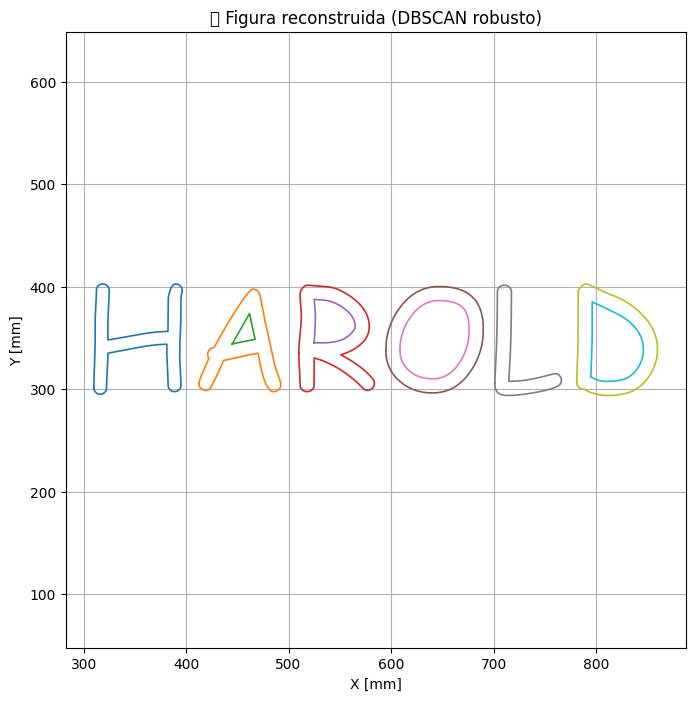

✅ Trayectoria exportada: trayectoria_XY_robusta.txt


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

📤 Descarga lista para MATLAB.


In [ ]:
# =============================================================
# 🦾 CONVERSOR DXF → TXT (robusto, método DBSCAN)
# Harold & Abril · versión final estable
# =============================================================

!pip install ezdxf shapely matplotlib numpy scipy scikit-learn --quiet

import ezdxf
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import LineString, MultiLineString
from shapely.ops import linemerge, unary_union
from scipy.interpolate import splprep, splev
from sklearn.cluster import DBSCAN
from google.colab import files

# -------------------------------------------------------------
# 1️⃣ SUBIR ARCHIVO DXF
# -------------------------------------------------------------
print("🔼 Sube tu archivo DXF (por ejemplo: figura_prueba.dxf)")
uploaded = files.upload()
dxf_file = list(uploaded.keys())[0]
print(f"✅ Archivo cargado: {dxf_file}")

# -------------------------------------------------------------
# 2️⃣ LECTOR DXF UNIVERSAL (solo XY)
# -------------------------------------------------------------
doc = ezdxf.readfile(dxf_file)
msp = doc.modelspace()
geoms = []

def procesar_entidad(e):
    dtype = e.dxftype()
    puntos = []
    try:
        if dtype == "LINE":
            start, end = e.dxf.start, e.dxf.end
            puntos = [[start.x, start.y], [end.x, end.y]]

        elif dtype == "LWPOLYLINE":
            pts = np.array(e.get_points())[:, :2]
            puntos = pts

        elif dtype == "POLYLINE":
            pts = [v.dxf.location[:2] for v in e.vertices]
            puntos = np.array(pts)

        elif dtype == "CIRCLE":
            c, r = e.dxf.center, e.dxf.radius
            t = np.linspace(0, 2*np.pi, 200)
            puntos = np.column_stack([c.x + r*np.cos(t), c.y + r*np.sin(t)])

        elif dtype == "ARC":
            c, r = e.dxf.center, e.dxf.radius
            a1, a2 = np.deg2rad(e.dxf.start_angle), np.deg2rad(e.dxf.end_angle)
            t = np.linspace(a1, a2, 120)
            puntos = np.column_stack([c.x + r*np.cos(t), c.y + r*np.sin(t)])

        elif dtype == "SPLINE":
            fit = np.array(e.fit_points)
            if len(fit) >= 2:
                tck, _ = splprep([fit[:,0], fit[:,1]], s=0)
                u = np.linspace(0, 1, 200)
                x, y = splev(u, tck)
                puntos = np.column_stack([x, y])
            else:
                ctrl = np.array(e.control_points)
                if len(ctrl) >= 2:
                    tck, _ = splprep([ctrl[:,0], ctrl[:,1]], s=0)
                    u = np.linspace(0, 1, 200)
                    x, y = splev(u, tck)
                    puntos = np.column_stack([x, y])

        if len(puntos) > 1:
            geoms.append(LineString(puntos))

    except Exception as ex:
        print(f"⚠️ No se pudo procesar {dtype}: {ex}")

for e in msp:
    procesar_entidad(e)

if not geoms:
    raise ValueError("⚠️ No se detectaron entidades válidas en el DXF.")

# -------------------------------------------------------------
# 3️⃣ AGRUPAR EXTREMOS (DBSCAN)
# -------------------------------------------------------------
tolerancia_endpoints = 0.05  # mm
print(f"🔧 Agrupando endpoints con tolerancia = {tolerancia_endpoints} mm")

endpoints = []
endpoint_map = []
for gi, g in enumerate(geoms):
    coords = list(g.coords)
    endpoints.append(coords[0])
    endpoint_map.append((gi, 0))
    endpoints.append(coords[-1])
    endpoint_map.append((gi, -1))

endpoints = np.array(endpoints)
cl = DBSCAN(eps=tolerancia_endpoints, min_samples=1, metric='euclidean')
labels = cl.fit_predict(endpoints)
n_clusters = labels.max() + 1
print(f"🔹 Clusters de endpoints detectados: {n_clusters}")

# Calcular centroides
centroids = np.zeros((n_clusters, 2))
for k in range(n_clusters):
    pts = endpoints[labels == k]
    centroids[k] = pts.mean(axis=0)

# Reemplazar extremos por centroides
geoms_sanitized = []
for gi, g in enumerate(geoms):
    coords = list(g.coords)
    label_start = labels[2*gi]
    label_end = labels[2*gi + 1]
    new_coords = coords.copy()
    new_coords[0] = tuple(centroids[label_start])
    new_coords[-1] = tuple(centroids[label_end])
    geoms_sanitized.append(LineString(new_coords))

# -------------------------------------------------------------
# 4️⃣ UNIR LÍNEAS CONECTADAS
# -------------------------------------------------------------
union = unary_union(geoms_sanitized)
merged = linemerge(union)

if isinstance(merged, LineString):
    merged = [merged]
elif isinstance(merged, MultiLineString):
    merged = list(merged.geoms)

print(f"✅ Total de trayectorias finales: {len(merged)}")

# -------------------------------------------------------------
# 5️⃣ GRAFICAR RESULTADO
# -------------------------------------------------------------
plt.figure(figsize=(8,8))
for i, g in enumerate(merged):
    x, y = g.xy
    plt.plot(x, y, linewidth=1.2, label=f"Trayectoria {i+1}")
plt.axis('equal')
plt.title("🧩 Figura reconstruida (DBSCAN robusto)")
plt.xlabel("X [mm]")
plt.ylabel("Y [mm]")
plt.grid(True)
plt.show()

# -------------------------------------------------------------
# 6️⃣ EXPORTAR A TXT
# -------------------------------------------------------------
txt_filename = "trayectoria_XY_robusta.txt"
with open(txt_filename, 'w') as f:
    f.write("X Y\n")
    for geom in merged:
        x, y = geom.xy
        for xi, yi in zip(x, y):
            f.write(f"{xi:.6f} {yi:.6f}\n")
        f.write("NaN NaN\n")

print(f"✅ Trayectoria exportada: {txt_filename}")
files.download(txt_filename)
print("📤 Descarga lista para MATLAB.")

UNIDADES: Se asume que el DXF usa mm. Si tu DXF está en m, convierte afuera.
Z_guardado [mm] [200.0]: 200
Z_corte [mm] [150.0]: 150
Velocidad_transicion [mm/s] [50.0]: 50
Velocidad_corte [mm/s] [20.0]: 20
📂 Sube el archivo DXF que deseas procesar:


Saving logo7-new.dxf to logo7-new (11).dxf
✅ Archivo cargado: logo7-new (11).dxf
Total entidades: 130 | Corte: 114 | No corte (amarillo): 16
Grupos detectados (merged): 112
Orden de recorrido (indices): [1, 6, 8, 9, 2, 0, 7, 5, 4, 3, 15, 16, 18, 19, 20, 25, 23, 24, 14, 21, 13, 10, 11, 12, 22, 17, 27, 26, 30, 28, 29, 33, 34, 35, 36, 31, 32, 38, 40, 42, 43, 44, 46, 54, 51, 48, 53, 63, 64, 68, 69, 67, 66, 61, 62, 52, 50, 47, 49, 57, 60, 59, 55, 45, 56, 70, 65, 73, 72, 71, 58, 41, 37, 39, 76, 84, 79, 77, 83, 81, 75, 74, 78, 80, 82, 85, 88, 89, 87, 86, 91, 97, 98, 100, 102, 103, 95, 94, 90, 106, 105, 109, 110, 111, 108, 107, 101, 104, 96, 92, 93, 99]
Total puntos en trayectoria (incl. NaN sep): 14521


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Exportado: Trayectoria_final_3D.txt


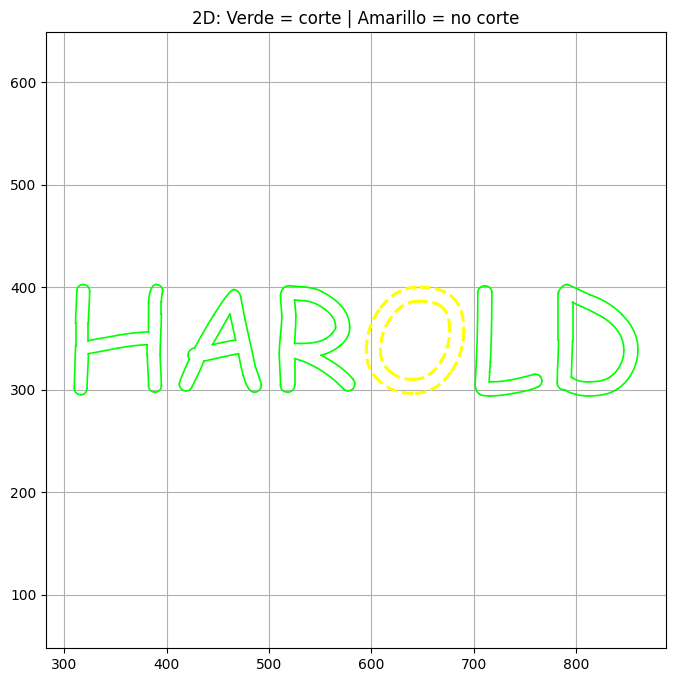

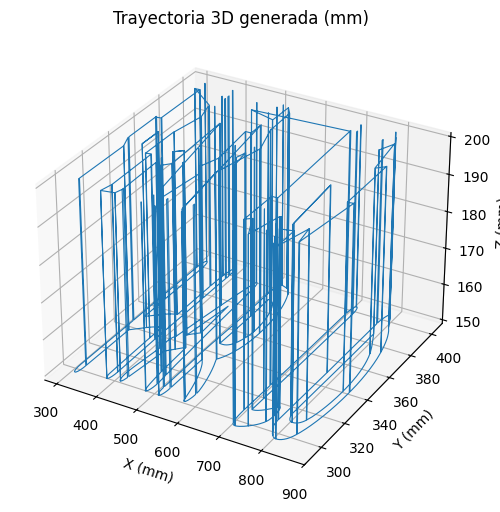

In [ ]:
# =============================================================
# 🦾 DXF -> Trayectoria 3D SCARA (DBSCAN + color real + perfiles)
# Harold & Abril · versión final: transiciones + S-curve corte + trapezoidal salto
# Output: Trayectoria_final_3D.txt (X Y Z V), NaN NaN NaN NaN entre grupos
# =============================================================

!pip install ezdxf shapely matplotlib numpy scipy scikit-learn --quiet

import ezdxf
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import LineString, MultiLineString
from shapely.ops import linemerge, unary_union
from scipy.interpolate import splprep, splev
from sklearn.cluster import DBSCAN
from google.colab import files
import math

# -------------------------
# Parámetros fijos / supuestos
# -------------------------
ASSUME_DXF_UNITS_MM = True   # asumo que las coordenadas DXF están en mm
PASO_MM = 1.0                # paso de muestreo en XY en mm (fijo, denso)
N_Z_STEPS = 50               # pasos en subida/bajada vertical
TRANSIT_ACCEL_FRAC = 0.2     # fracción para rampa en perfil trapezoidal (20% accel, 60% const, 20% decel)
# -------------------------

# -------------------- 1) Pedir parámetros mínimos (solo 4) --------------------
def pedir_float(msg, default):
    s = input(f"{msg} [{default}]: ").strip()
    return float(s) if s != "" else float(default)

print("UNIDADES: Se asume que el DXF usa mm. Si tu DXF está en m, convierte afuera.")
Z_guardado = pedir_float("Z_guardado [mm]", 200.0)
Z_corte    = pedir_float("Z_corte [mm]", 150.0)
V_trans    = pedir_float("Velocidad_transicion [mm/s]", 50.0)   # para saltos/subidas
V_corte    = pedir_float("Velocidad_corte [mm/s]", 20.0)       # para corte (lineal sobre material)

# convertir velocidades to mm (we keep mm units internally)
paso = PASO_MM
Zg = Z_guardado
Zc = Z_corte
n_z = int(N_Z_STEPS)

# -------------------- 2) Cargar DXF --------------------
print("📂 Sube el archivo DXF que deseas procesar:")
uploaded = files.upload()
dxf_file = list(uploaded.keys())[0]
print(f"✅ Archivo cargado: {dxf_file}")

doc = ezdxf.readfile(dxf_file)
msp = doc.modelspace()

# -------------------- 3) Leer entidades (tu lector robusto) --------------------
geoms = []
colores = []

def obtener_color_real(ent):
    """Devuelve color ACI (int) o truecolor (tuple) si está presente, o color de la capa."""
    try:
        # true color:
        if hasattr(ent.dxf, "true_color") and ent.dxf.get("true_color", None):
            try:
                rgb = ent.rgb
                if rgb is not None:
                    return tuple(rgb)  # (r,g,b)
            except Exception:
                pass
        color_index = int(getattr(ent.dxf, "color", 7))
        if color_index <= 0 or color_index == 256:
            # usar color de la capa
            layer = ent.dxf.layer
            layer_color_index = int(doc.layers.get(layer).color)
            return layer_color_index
        return color_index
    except Exception:
        return 7

def procesar_entidad(e):
    dtype = e.dxftype()
    color = obtener_color_real(e)
    puntos = []
    try:
        if dtype == "LINE":
            s, e2 = e.dxf.start, e.dxf.end
            puntos = [[s.x, s.y], [e2.x, e2.y]]
        elif dtype == "LWPOLYLINE":
            pts = np.array(e.get_points())[:, :2]
            puntos = pts
        elif dtype == "POLYLINE":
            pts = [v.dxf.location[:2] for v in e.vertices]
            puntos = np.array(puntos) if len(pts)==0 else np.array(pts)
        elif dtype == "CIRCLE":
            c, r = e.dxf.center, e.dxf.radius
            t = np.linspace(0, 2*np.pi, 200)
            puntos = np.column_stack([c.x + r*np.cos(t), c.y + r*np.sin(t)])
        elif dtype == "ARC":
            c, r = e.dxf.center, e.dxf.radius
            a1, a2 = np.deg2rad(e.dxf.start_angle), np.deg2rad(e.dxf.end_angle)
            t = np.linspace(a1, a2, 120)
            puntos = np.column_stack([c.x + r*np.cos(t), c.y + r*np.sin(t)])
        elif dtype == "SPLINE":
            fit = np.array(e.fit_points)
            if len(fit) >= 2:
                tck, _ = splprep([fit[:,0], fit[:,1]], s=0)
                u = np.linspace(0, 1, 200)
                x, y = splev(u, tck)
                puntos = np.column_stack([x, y])
            else:
                ctrl = np.array(e.control_points)
                if len(ctrl) >= 2:
                    tck, _ = splprep([ctrl[:,0], ctrl[:,1]], s=0)
                    u = np.linspace(0, 1, 200)
                    x, y = splev(u, tck)
                    puntos = np.column_stack([x, y])
        if len(puntos) > 1:
            geoms.append(LineString(puntos))
            colores.append(color)
    except Exception as ex:
        print(f"⚠️ No se pudo procesar {dtype}: {ex}")

for ent in msp:
    procesar_entidad(ent)

if not geoms:
    raise ValueError("No se detectaron entidades válidas en el DXF.")

# -------------------- 4) Clasificar por color: corte / no corte --------------------
def es_amarillo(c):
    if isinstance(c, (tuple, list)):
        r,g,b = c
        return (r >= 200 and g >= 200 and b <= 120)
    else:
        try:
            return int(c) == 2
        except:
            return False

geoms_corte_raw = []
geoms_nocorte_raw = []
for g,c in zip(geoms, colores):
    if es_amarillo(c):
        geoms_nocorte_raw.append(g)
    else:
        geoms_corte_raw.append(g)

print(f"Total entidades: {len(geoms)} | Corte: {len(geoms_corte_raw)} | No corte (amarillo): {len(geoms_nocorte_raw)}")

# -------------------- 5) Sanitizar / unir geoms de corte (linemerge) --------------------
if len(geoms_corte_raw) == 0:
    raise ValueError("No hay entidades de corte (todas amarillas?)")

union = unary_union(geoms_corte_raw)
merged = linemerge(union)
if isinstance(merged, LineString):
    merged = [merged]
elif isinstance(merged, MultiLineString):
    merged = list(merged.geoms)

# merged ahora contiene trayectorias continuas (cada elemento = un 'grupo' candidato)
groups = merged  # lista de LineString
print(f"Grupos detectados (merged): {len(groups)}")

# -------------------- 6) Resample helper --------------------
def resample_linestring(ls: LineString, paso_mm=1.0):
    pts = np.array(ls.coords)
    segs = np.linalg.norm(np.diff(pts, axis=0), axis=1)
    if segs.sum() == 0:
        return pts
    s = np.concatenate(([0.0], np.cumsum(segs)))
    s_new = np.arange(0, s[-1] + 1e-9, paso_mm)
    xs = np.interp(s_new, s, pts[:,0])
    ys = np.interp(s_new, s, pts[:,1])
    return np.vstack([xs, ys]).T

# -------------------- 7) Orden óptimo de grupos (nearest neighbor sobre centroides) --------------------
centers = np.array([np.array(g.centroid.coords[0]) for g in groups])
def nearest_neighbor_order(centers):
    n = len(centers)
    if n == 0: return []
    remaining = set(range(n))
    # init at centroid nearest to origin (0,0)
    start = int(np.argmin([np.linalg.norm(c - np.array([0.0,0.0])) for c in centers]))
    order = [start]; remaining.remove(start)
    cur = start
    while remaining:
        nxt = min(remaining, key=lambda j: np.linalg.norm(centers[cur]-centers[j]))
        order.append(nxt)
        remaining.remove(nxt)
        cur = nxt
    return order

order = nearest_neighbor_order(centers)
print("Orden de recorrido (indices):", order)

# -------------------- 8) Perfiles de velocidad --------------------
def perfil_trapezoidal(dist, v_max, frac_acc=TRANSIT_ACCEL_FRAC, steps=None):
    # crear vector de velocidades a lo largo de la distancia (length = steps)
    if steps is None or steps < 2:
        steps = max(2, int(np.ceil(dist / paso)))
    t = np.linspace(0, 1, steps)
    acc_t = frac_acc
    dec_t = 1 - frac_acc
    vmax = v_max
    def piece(ti):
        if ti < acc_t:
            return vmax * (ti / acc_t)
        elif ti > dec_t:
            return vmax * (1 - (ti - dec_t)/(1 - dec_t))
        else:
            return vmax
    vec = np.array([piece(ti) for ti in t])
    return vec

def perfil_s_curve(steps, v_max):
    t = np.linspace(0, 1, steps)
    # suavizado tipo sin (0->1): v = v_max * (0.5 - 0.5 cos(pi t))
    v = v_max * (0.5 - 0.5 * np.cos(np.pi * t))
    return v

# -------------------- 9) Construir trayectoria 3D final (solo grupos de corte) --------------------
tray_pts = []   # list of [x,y,z,v]
visual_3d = []  # for plotting

prev_guard_xy = None

for idx in order:
    group = groups[idx]
    # sample XY of this group
    pts_xy = resample_linestring(group, paso_mm=PASO_MM)
    if pts_xy.shape[0] < 2:
        continue

    # Decide orientation minimizing transit distance from prev_guard_xy
    start_xy = pts_xy[0]; end_xy = pts_xy[-1]
    if prev_guard_xy is None:
        # choose orientation where start closer to origin
        if np.linalg.norm(end_xy - np.array([0.0,0.0])) < np.linalg.norm(start_xy - np.array([0.0,0.0])):
            pts_xy = pts_xy[::-1]
            start_xy = pts_xy[0]; end_xy = pts_xy[-1]
    else:
        d_start = np.linalg.norm(prev_guard_xy - start_xy)
        d_end   = np.linalg.norm(prev_guard_xy - end_xy)
        if d_end < d_start:
            pts_xy = pts_xy[::-1]
            start_xy = pts_xy[0]; end_xy = pts_xy[-1]

    # 1) Transit at Z_guardado from prev_guard_xy to start_xy (if prev exists)
    if prev_guard_xy is None:
        # initial move: jump to first start at Zg (no long transit)
        transit_xy = np.array([start_xy])
    else:
        dist_transit = np.linalg.norm(start_xy - prev_guard_xy)
        n_steps_trans = max(2, int(np.ceil(dist_transit / PASO_MM)))
        xs = np.linspace(prev_guard_xy[0], start_xy[0], n_steps_trans)
        ys = np.linspace(prev_guard_xy[1], start_xy[1], n_steps_trans)
        transit_xy = np.column_stack([xs, ys])

    # transit points at Zg with trapezoidal profile using V_trans
    n_t = transit_xy.shape[0]
    v_trans_profile = perfil_trapezoidal(dist=np.sum(np.linalg.norm(np.diff(transit_xy, axis=0), axis=1)),
                                         v_max=V_trans, steps=n_t)
    for p, vv in zip(transit_xy, v_trans_profile):
        tray_pts.append([p[0], p[1], Zg, vv])
        visual_3d.append([p[0], p[1], Zg])

    # 2) Descent vertical to Zc (n_z steps) at start_xy (use V_trans)
    zs_desc = np.linspace(Zg, Zc, n_z)
    for z in zs_desc:
        tray_pts.append([start_xy[0], start_xy[1], z, V_trans])
        visual_3d.append([start_xy[0], start_xy[1], z])

    # 3) Cut along pts_xy at Zc with S-curve profile and V_corte
    n_cut = pts_xy.shape[0]
    v_cut_profile = perfil_s_curve(n_cut, V_corte)
    for (p, vv) in zip(pts_xy, v_cut_profile):
        tray_pts.append([p[0], p[1], Zc, float(vv)])
        visual_3d.append([p[0], p[1], Zc])

    # 4) Ascent vertical to Zg (n_z steps) at end point
    zs_asc = np.linspace(Zc, Zg, n_z)
    last_xy = pts_xy[-1]
    for z in zs_asc:
        tray_pts.append([last_xy[0], last_xy[1], z, V_trans])
        visual_3d.append([last_xy[0], last_xy[1], z])

    # mark separator by appending a NaN sentinel row (we'll write NaN separators when exporting)
    tray_pts.append([np.nan, np.nan, np.nan, np.nan])

    # update prev_guard_xy
    prev_guard_xy = np.array([last_xy[0], last_xy[1]])

# remove trailing NaN if present
if len(tray_pts) and all([math.isnan(x) for x in tray_pts[-1]]):
    pass  # keep final NaN separator (okay)

tray_arr = np.array(tray_pts, dtype=float)
print(f"Total puntos en trayectoria (incl. NaN sep): {tray_arr.shape[0]}")

# -------------------- 10) Exportar Trayectoria_final_3D.txt --------------------
outname = "Trayectoria_final_3D.txt"
with open(outname, "w") as f:
    f.write("X Y Z V\n")
    for row in tray_arr:
        if np.isnan(row).any():
            f.write("NaN NaN NaN NaN\n")
        else:
            f.write(f"{row[0]:.6f} {row[1]:.6f} {row[2]:.6f} {row[3]:.6f}\n")

files.download(outname)
print(f"✅ Exportado: {outname}")

# -------------------- 11) Visualizaciones --------------------
# 2D plot (verde = corte, amarillo = no corte)
plt.figure(figsize=(8,8))
for g in geoms_corte_raw:
    x,y = g.xy
    plt.plot(x,y,color="#00ff00", linewidth=1.2)
for g in geoms_nocorte_raw:
    x,y = g.xy
    plt.plot(x,y,color="yellow", linewidth=2.2, linestyle="--")
plt.axis("equal"); plt.title("2D: Verde = corte | Amarillo = no corte"); plt.grid(True)
plt.show()

# 3D plot of final trajectory
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
tp = np.array(visual_3d)
if tp.size:
    ax.plot(tp[:,0], tp[:,1], tp[:,2], linewidth=0.8)
ax.set_xlabel("X (mm)"); ax.set_ylabel("Y (mm)"); ax.set_zlabel("Z (mm)")
ax.set_title("Trayectoria 3D generada (mm)")
plt.show()


📂 Sube el archivo DXF que deseas procesar:


Saving logo7-new.dxf to logo7-new (21).dxf
✅ Archivo cargado: logo7-new (21).dxf
✂️ Figuras a cortar: 114
🚫 Figuras NO cortar: 16
✅ Trayectorias finales: cortar = 8, no cortar = 2


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


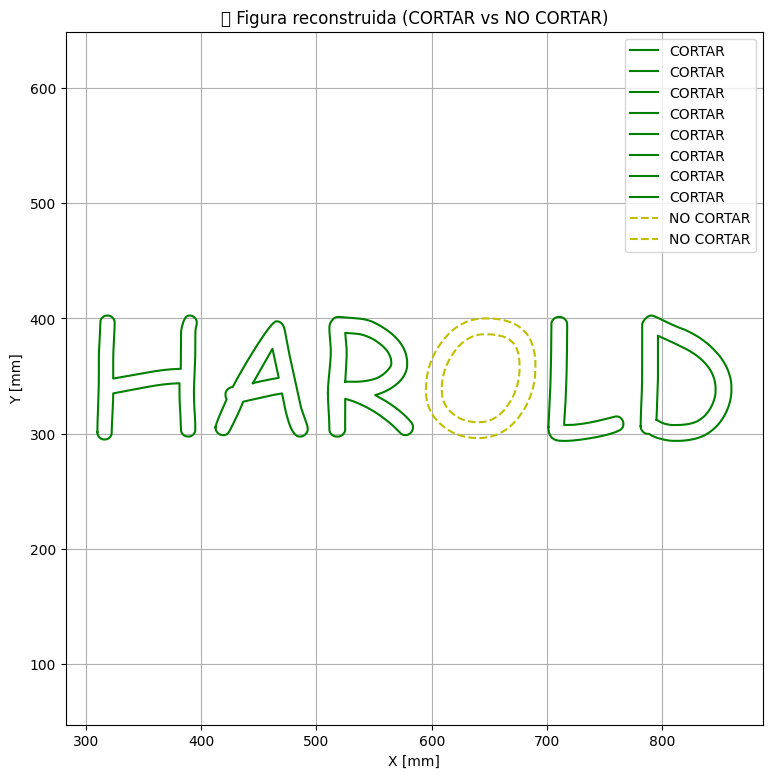

✅ Exportado: trayectoria_CORTAR.txt


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Exportado: trayectoria_NO_CORTAR.txt


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

📤 Descarga lista para MATLAB o simulador SCARA.


In [ ]:
# =============================================================
# 🦾 CONVERSOR DXF → TXT SCARA-CNC (topología + color)
# Harold & Abril · versión unificada estable · 2025
# =============================================================

!pip install ezdxf shapely matplotlib numpy scipy scikit-learn --quiet

import ezdxf
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import LineString, MultiLineString
from shapely.ops import linemerge, unary_union
from scipy.interpolate import splprep, splev
from sklearn.cluster import DBSCAN
from google.colab import files

# -------------------------------------------------------------
# 1️⃣ SUBIR ARCHIVO DXF
# -------------------------------------------------------------
print("📂 Sube el archivo DXF que deseas procesar:")
uploaded = files.upload()
dxf_file = list(uploaded.keys())[0]
print(f"✅ Archivo cargado: {dxf_file}")

# -------------------------------------------------------------
# 2️⃣ LECTOR DXF UNIVERSAL (XY + color)
# -------------------------------------------------------------
doc = ezdxf.readfile(dxf_file)
msp = doc.modelspace()
geoms = []

def procesar_entidad(e):
    dtype = e.dxftype()
    color = e.dxf.color
    layer = e.dxf.layer
    puntos = []
    try:
        if dtype == "LINE":
            start, end = e.dxf.start, e.dxf.end
            puntos = [[start.x, start.y], [end.x, end.y]]

        elif dtype == "LWPOLYLINE":
            pts = np.array(e.get_points())[:, :2]
            puntos = pts

        elif dtype == "POLYLINE":
            pts = [v.dxf.location[:2] for v in e.vertices]
            puntos = np.array(pts)

        elif dtype == "CIRCLE":
            c, r = e.dxf.center, e.dxf.radius
            t = np.linspace(0, 2*np.pi, 200)
            puntos = np.column_stack([c.x + r*np.cos(t), c.y + r*np.sin(t)])

        elif dtype == "ARC":
            c, r = e.dxf.center, e.dxf.radius
            a1, a2 = np.deg2rad(e.dxf.start_angle), np.deg2rad(e.dxf.end_angle)
            t = np.linspace(a1, a2, 120)
            puntos = np.column_stack([c.x + r*np.cos(t), c.y + r*np.sin(t)])

        elif dtype == "SPLINE":
            fit = np.array(e.fit_points)
            if len(fit) >= 2:
                tck, _ = splprep([fit[:,0], fit[:,1]], s=0)
                u = np.linspace(0, 1, 200)
                x, y = splev(u, tck)
                puntos = np.column_stack([x, y])
            else:
                ctrl = np.array(e.control_points)
                if len(ctrl) >= 2:
                    tck, _ = splprep([ctrl[:,0], ctrl[:,1]], s=0)
                    u = np.linspace(0, 1, 200)
                    x, y = splev(u, tck)
                    puntos = np.column_stack([x, y])

        if len(puntos) > 1:
            geoms.append({
                "geom": LineString(puntos),
                "color": color,
                "layer": layer
            })

    except Exception as ex:
        print(f"⚠️ No se pudo procesar {dtype}: {ex}")

for e in msp:
    procesar_entidad(e)

if not geoms:
    raise ValueError("⚠️ No se detectaron entidades válidas en el DXF.")

# -------------------------------------------------------------
# 3️⃣ SEPARAR POR COLOR (CORTAR / NO CORTAR)
# -------------------------------------------------------------
def clasificar_color(color, layer):
    # Códigos DXF típicos: amarillo = 2
    if color == 2 or "NO" in layer.upper():
        return "NO_CORTAR"
    else:
        return "CORTAR"

geoms_cortar = [g["geom"] for g in geoms if clasificar_color(g["color"], g["layer"]) == "CORTAR"]
geoms_nocortar = [g["geom"] for g in geoms if clasificar_color(g["color"], g["layer"]) == "NO_CORTAR"]

print(f"✂️ Figuras a cortar: {len(geoms_cortar)}")
print(f"🚫 Figuras NO cortar: {len(geoms_nocortar)}")

# -------------------------------------------------------------
# 4️⃣ FUNCIONES AUXILIARES DE AGRUPACIÓN (DBSCAN + UNION)
# -------------------------------------------------------------
def unir_topologicamente(geoms, tolerancia=0.05):
    if not geoms:
        return []
    endpoints = []
    endpoint_map = []
    for gi, g in enumerate(geoms):
        coords = list(g.coords)
        endpoints.append(coords[0])
        endpoint_map.append((gi, 0))
        endpoints.append(coords[-1])
        endpoint_map.append((gi, -1))

    endpoints = np.array(endpoints)
    cl = DBSCAN(eps=tolerancia, min_samples=1, metric='euclidean')
    labels = cl.fit_predict(endpoints)
    n_clusters = labels.max() + 1

    centroids = np.zeros((n_clusters, 2))
    for k in range(n_clusters):
        pts = endpoints[labels == k]
        centroids[k] = pts.mean(axis=0)

    geoms_sanitized = []
    for gi, g in enumerate(geoms):
        coords = list(g.coords)
        label_start = labels[2*gi]
        label_end = labels[2*gi + 1]
        new_coords = coords.copy()
        new_coords[0] = tuple(centroids[label_start])
        new_coords[-1] = tuple(centroids[label_end])
        geoms_sanitized.append(LineString(new_coords))

    union = unary_union(geoms_sanitized)
    merged = linemerge(union)
    if isinstance(merged, LineString):
        merged = [merged]
    elif isinstance(merged, MultiLineString):
        merged = list(merged.geoms)
    return merged

# -------------------------------------------------------------
# 5️⃣ UNIR CADA CATEGORÍA
# -------------------------------------------------------------
merged_cortar = unir_topologicamente(geoms_cortar)
merged_nocortar = unir_topologicamente(geoms_nocortar)

print(f"✅ Trayectorias finales: cortar = {len(merged_cortar)}, no cortar = {len(merged_nocortar)}")

# -------------------------------------------------------------
# 6️⃣ GRAFICAR RESULTADO
# -------------------------------------------------------------
plt.figure(figsize=(9,9))
for g in merged_cortar:
    x, y = g.xy
    plt.plot(x, y, 'g-', linewidth=1.5, label="CORTAR")
for g in merged_nocortar:
    x, y = g.xy
    plt.plot(x, y, 'y--', linewidth=1.5, label="NO CORTAR")

plt.axis('equal')
plt.title("🧩 Figura reconstruida (CORTAR vs NO CORTAR)")
plt.xlabel("X [mm]")
plt.ylabel("Y [mm]")
plt.grid(True)
plt.legend()
plt.show()

# -------------------------------------------------------------
# 7️⃣ EXPORTAR ARCHIVOS TXT
# -------------------------------------------------------------
def exportar_txt(nombre, lista_geoms):
    with open(nombre, 'w') as f:
        f.write("X Y\n")
        for geom in lista_geoms:
            x, y = geom.xy
            for xi, yi in zip(x, y):
                f.write(f"{xi:.6f} {yi:.6f}\n")
            f.write("NaN NaN\n")
    print(f"✅ Exportado: {nombre}")
    files.download(nombre)

exportar_txt("trayectoria_CORTAR.txt", merged_cortar)
exportar_txt("trayectoria_NO_CORTAR.txt", merged_nocortar)

print("📤 Descarga lista para MATLAB o simulador SCARA.")


📂 Sube el archivo DXF que deseas procesar:


Saving logo7-new.dxf to logo7-new (23).dxf
✅ Archivo cargado: logo7-new (23).dxf
Altura Z_guardado [mm]: 200
Altura Z_corte [mm]: 150
🦾 Alturas: Z_guardado=200.0 | Z_corte=150.0
✂️ Figuras a cortar: 114
🚫 Figuras NO cortar: 16
✅ Trayectorias finales: cortar = 8, no cortar = 2
📈 Total de puntos en trayectoria 3D: 18166


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129470 (\N{MECHANICAL ARM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


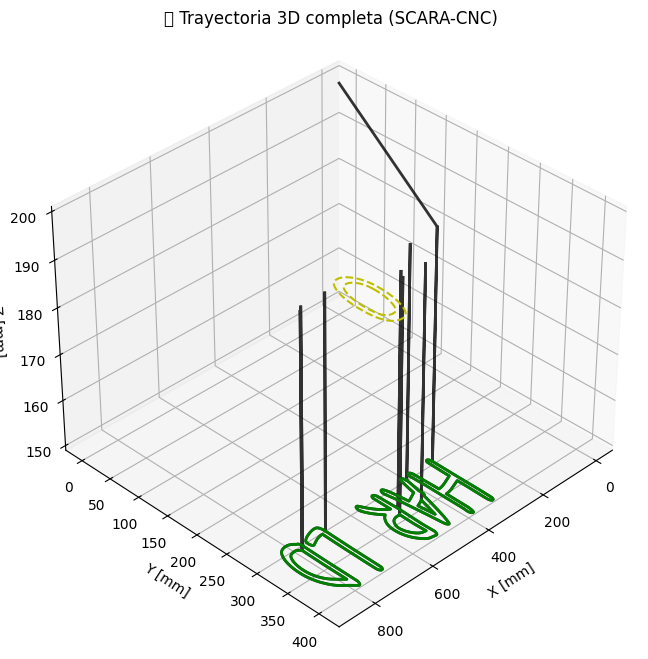

✅ Trayectoria 3D exportada: trayectoria_SCARA_3D.txt


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# =============================================================
# 🦾 CONVERSOR DXF → TRAYECTORIA 3D SCARA-CNC (topología + color)
# Harold & Abril · versión 3D corregida · 2025
# =============================================================

!pip install ezdxf shapely matplotlib numpy scipy scikit-learn --quiet

import ezdxf
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import LineString, MultiLineString
from shapely.ops import linemerge, unary_union
from scipy.interpolate import splprep, splev
from sklearn.cluster import DBSCAN
from google.colab import files
from mpl_toolkits.mplot3d import Axes3D

# -------------------------------------------------------------
# 1️⃣ SUBIR ARCHIVO DXF
# -------------------------------------------------------------
print("📂 Sube el archivo DXF que deseas procesar:")
uploaded = files.upload()
dxf_file = list(uploaded.keys())[0]
print(f"✅ Archivo cargado: {dxf_file}")

# -------------------------------------------------------------
# 2️⃣ PARÁMETROS SCARA
# -------------------------------------------------------------
Z_guardado = float(input("Altura Z_guardado [mm]: ") or 200)
Z_corte     = float(input("Altura Z_corte [mm]: ") or 150)
print(f"🦾 Alturas: Z_guardado={Z_guardado} | Z_corte={Z_corte}")

# -------------------------------------------------------------
# 3️⃣ LECTOR DXF UNIVERSAL (XY + color)
# -------------------------------------------------------------
doc = ezdxf.readfile(dxf_file)
msp = doc.modelspace()
geoms = []

def procesar_entidad(e):
    dtype = e.dxftype()
    color = e.dxf.color
    layer = e.dxf.layer
    puntos = []
    try:
        if dtype == "LINE":
            start, end = e.dxf.start, e.dxf.end
            puntos = [[start.x, start.y], [end.x, end.y]]

        elif dtype == "LWPOLYLINE":
            pts = np.array(e.get_points())[:, :2]
            puntos = pts

        elif dtype == "POLYLINE":
            pts = [v.dxf.location[:2] for v in e.vertices]
            puntos = np.array(pts)

        elif dtype == "CIRCLE":
            c, r = e.dxf.center, e.dxf.radius
            t = np.linspace(0, 2*np.pi, 200)
            puntos = np.column_stack([c.x + r*np.cos(t), c.y + r*np.sin(t)])

        elif dtype == "ARC":
            c, r = e.dxf.center, e.dxf.radius
            a1, a2 = np.deg2rad(e.dxf.start_angle), np.deg2rad(e.dxf.end_angle)
            t = np.linspace(a1, a2, 120)
            puntos = np.column_stack([c.x + r*np.cos(t), c.y + r*np.sin(t)])

        elif dtype == "SPLINE":
            fit = np.array(e.fit_points)
            if len(fit) >= 2:
                tck, _ = splprep([fit[:,0], fit[:,1]], s=0)
                u = np.linspace(0, 1, 200)
                x, y = splev(u, tck)
                puntos = np.column_stack([x, y])
            else:
                ctrl = np.array(e.control_points)
                if len(ctrl) >= 2:
                    tck, _ = splprep([ctrl[:,0], ctrl[:,1]], s=0)
                    u = np.linspace(0, 1, 200)
                    x, y = splev(u, tck)
                    puntos = np.column_stack([x, y])

        if len(puntos) > 1:
            geoms.append({
                "geom": LineString(puntos),
                "color": color,
                "layer": layer
            })

    except Exception as ex:
        print(f"⚠️ No se pudo procesar {dtype}: {ex}")

for e in msp:
    procesar_entidad(e)

if not geoms:
    raise ValueError("⚠️ No se detectaron entidades válidas en el DXF.")

# -------------------------------------------------------------
# 4️⃣ CLASIFICAR POR COLOR (CORTAR / NO CORTAR)
# -------------------------------------------------------------
def clasificar_color(color, layer):
    if color == 2 or "NO" in layer.upper():
        return "NO_CORTAR"
    else:
        return "CORTAR"

geoms_cortar = [g["geom"] for g in geoms if clasificar_color(g["color"], g["layer"]) == "CORTAR"]
geoms_nocortar = [g["geom"] for g in geoms if clasificar_color(g["color"], g["layer"]) == "NO_CORTAR"]

print(f"✂️ Figuras a cortar: {len(geoms_cortar)}")
print(f"🚫 Figuras NO cortar: {len(geoms_nocortar)}")

# -------------------------------------------------------------
# 5️⃣ UNIÓN TOPOLOGICA (DBSCAN + UNION)
# -------------------------------------------------------------
def unir_topologicamente(geoms, tolerancia=0.05):
    if not geoms:
        return []
    endpoints = []
    endpoint_map = []
    for gi, g in enumerate(geoms):
        coords = list(g.coords)
        endpoints.append(coords[0])
        endpoint_map.append((gi, 0))
        endpoints.append(coords[-1])
        endpoint_map.append((gi, -1))

    endpoints = np.array(endpoints)
    cl = DBSCAN(eps=tolerancia, min_samples=1)
    labels = cl.fit_predict(endpoints)
    n_clusters = labels.max() + 1

    centroids = np.zeros((n_clusters, 2))
    for k in range(n_clusters):
        pts = endpoints[labels == k]
        centroids[k] = pts.mean(axis=0)

    geoms_sanitized = []
    for gi, g in enumerate(geoms):
        coords = list(g.coords)
        label_start = labels[2*gi]
        label_end = labels[2*gi + 1]
        coords[0] = tuple(centroids[label_start])
        coords[-1] = tuple(centroids[label_end])
        geoms_sanitized.append(LineString(coords))

    union = unary_union(geoms_sanitized)
    merged = linemerge(union)
    return [merged] if isinstance(merged, LineString) else list(merged.geoms)

merged_cortar = unir_topologicamente(geoms_cortar)
merged_nocortar = unir_topologicamente(geoms_nocortar)

print(f"✅ Trayectorias finales: cortar = {len(merged_cortar)}, no cortar = {len(merged_nocortar)}")

# -------------------------------------------------------------
# 6️⃣ CONSTRUIR TRAYECTORIA 3D COMPLETA
# -------------------------------------------------------------
trayectoria_3D = []
trayectoria_3D.append(np.array([[0, 0, Z_guardado]]))  # punto inicial

for i, grupo in enumerate(merged_cortar):
    x, y = grupo.xy
    inicio = np.array([[x[0], y[0], Z_guardado]])
    desc = np.array([[x[0], y[0], Z_corte]])
    corte = np.column_stack([x, y, np.ones_like(x)*Z_corte])
    sube = np.array([[x[-1], y[-1], Z_guardado]])

    trayectoria_3D.append(np.vstack([inicio, desc, corte, sube, np.full((1,3), np.nan)]))

# Final: regresar al home
trayectoria_3D.append(np.array([[0, 0, Z_guardado]]))
trayectoria_total = np.vstack(trayectoria_3D)

print(f"📈 Total de puntos en trayectoria 3D: {np.sum(~np.isnan(trayectoria_total[:,0]))}")

# -------------------------------------------------------------
# 7️⃣ GRAFICAR 3D
# -------------------------------------------------------------
fig = plt.figure(figsize=(9,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(trayectoria_total[:,0], trayectoria_total[:,1], trayectoria_total[:,2], 'k-', linewidth=2, alpha=0.8)

for g in merged_cortar:
    x, y = g.xy
    z = np.ones_like(x) * Z_corte
    ax.plot(x, y, z, 'g-', linewidth=2)

for g in merged_nocortar:
    x, y = g.xy
    z = np.ones_like(x) * Z_guardado
    ax.plot(x, y, z, 'y--', linewidth=1.5)

ax.set_title("🦾 Trayectoria 3D completa (SCARA-CNC)")
ax.set_xlabel("X [mm]")
ax.set_ylabel("Y [mm]")
ax.set_zlabel("Z [mm]")
ax.view_init(elev=35, azim=45)
plt.show()

# -------------------------------------------------------------
# 8️⃣ EXPORTAR TXT 3D
# -------------------------------------------------------------
nombre_txt = "trayectoria_SCARA_3D.txt"
with open(nombre_txt, 'w') as f:
    f.write("X Y Z\n")
    for x, y, z in trayectoria_total:
        if np.isnan(x):
            f.write("NaN NaN NaN\n")
        else:
            f.write(f"{x:.6f} {y:.6f} {z:.6f}\n")
print(f"✅ Trayectoria 3D exportada: {nombre_txt}")
files.download(nombre_txt)


🔼 Sube tu archivo DXF (por ejemplo: figura_prueba.dxf)


Saving logo7-new.dxf to logo7-new (30).dxf
✅ Archivo cargado: logo7-new (30).dxf
🔧 Agrupando endpoints con tolerancia = 0.05 mm
🔹 Clusters de endpoints detectados: 130
✅ Total de trayectorias finales: 10


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


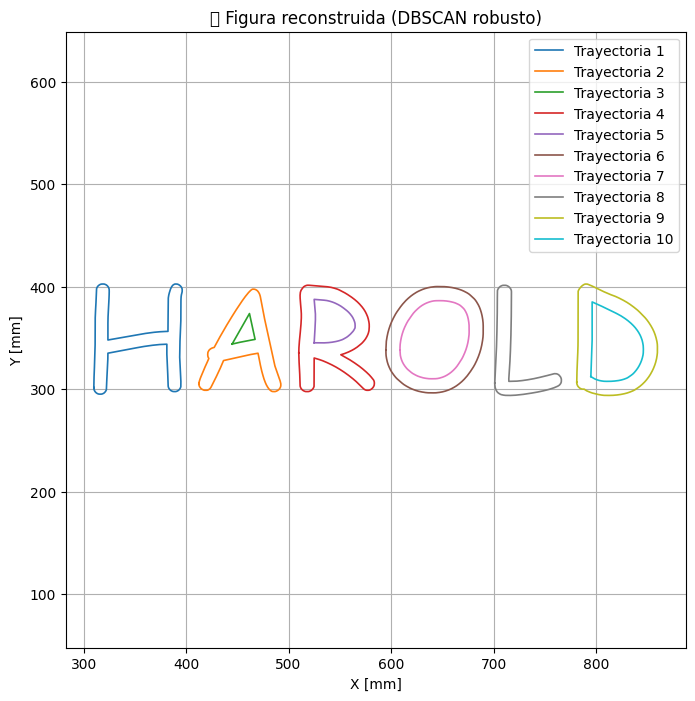

✅ Archivo exportado: trayectoria_SCARA_ready.txt


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

📤 Archivo listo para leer en MATLAB con LeerGruposTrayectoria.m


In [ ]:
# =============================================================
# 🦾 CONVERSOR DXF → TXT (versión SCARA ready)
# Harold & Abril · flujo integrado DXF → MATLAB
# =============================================================

!pip install ezdxf shapely matplotlib numpy scipy scikit-learn --quiet

import ezdxf
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import LineString, MultiLineString
from shapely.ops import linemerge, unary_union
from scipy.interpolate import splprep, splev
from sklearn.cluster import DBSCAN
from google.colab import files

# -------------------------------------------------------------
# 1️⃣ SUBIR ARCHIVO DXF
# -------------------------------------------------------------
print("🔼 Sube tu archivo DXF (por ejemplo: figura_prueba.dxf)")
uploaded = files.upload()
dxf_file = list(uploaded.keys())[0]
print(f"✅ Archivo cargado: {dxf_file}")

# -------------------------------------------------------------
# 2️⃣ LECTOR DXF UNIVERSAL (solo XY)
# -------------------------------------------------------------
doc = ezdxf.readfile(dxf_file)
msp = doc.modelspace()
geoms = []

def procesar_entidad(e):
    dtype = e.dxftype()
    puntos = []
    try:
        if dtype == "LINE":
            start, end = e.dxf.start, e.dxf.end
            puntos = [[start.x, start.y], [end.x, end.y]]

        elif dtype == "LWPOLYLINE":
            pts = np.array(e.get_points())[:, :2]
            puntos = pts

        elif dtype == "POLYLINE":
            pts = [v.dxf.location[:2] for v in e.vertices]
            puntos = np.array(pts)

        elif dtype == "CIRCLE":
            c, r = e.dxf.center, e.dxf.radius
            t = np.linspace(0, 2*np.pi, 200)
            puntos = np.column_stack([c.x + r*np.cos(t), c.y + r*np.sin(t)])

        elif dtype == "ARC":
            c, r = e.dxf.center, e.dxf.radius
            a1, a2 = np.deg2rad(e.dxf.start_angle), np.deg2rad(e.dxf.end_angle)
            t = np.linspace(a1, a2, 120)
            puntos = np.column_stack([c.x + r*np.cos(t), c.y + r*np.sin(t)])

        elif dtype == "SPLINE":
            fit = np.array(e.fit_points)
            if len(fit) >= 2:
                tck, _ = splprep([fit[:,0], fit[:,1]], s=0)
                u = np.linspace(0, 1, 200)
                x, y = splev(u, tck)
                puntos = np.column_stack([x, y])
            else:
                ctrl = np.array(e.control_points)
                if len(ctrl) >= 2:
                    tck, _ = splprep([ctrl[:,0], ctrl[:,1]], s=0)
                    u = np.linspace(0, 1, 200)
                    x, y = splev(u, tck)
                    puntos = np.column_stack([x, y])

        if len(puntos) > 1:
            geoms.append(LineString(puntos))

    except Exception as ex:
        print(f"⚠️ No se pudo procesar {dtype}: {ex}")

for e in msp:
    procesar_entidad(e)

if not geoms:
    raise ValueError("⚠️ No se detectaron entidades válidas en el DXF.")

# -------------------------------------------------------------
# 3️⃣ AGRUPAR EXTREMOS CON DBSCAN
# -------------------------------------------------------------
tolerancia_endpoints = 0.05  # mm
print(f"🔧 Agrupando endpoints con tolerancia = {tolerancia_endpoints} mm")

endpoints = []
endpoint_map = []
for gi, g in enumerate(geoms):
    coords = list(g.coords)
    endpoints.append(coords[0])
    endpoint_map.append((gi, 0))
    endpoints.append(coords[-1])
    endpoint_map.append((gi, -1))

endpoints = np.array(endpoints)
cl = DBSCAN(eps=tolerancia_endpoints, min_samples=1, metric='euclidean')
labels = cl.fit_predict(endpoints)
n_clusters = labels.max() + 1
print(f"🔹 Clusters de endpoints detectados: {n_clusters}")

# Reemplazar extremos por centroides
centroids = np.zeros((n_clusters, 2))
for k in range(n_clusters):
    pts = endpoints[labels == k]
    centroids[k] = pts.mean(axis=0)

geoms_sanitized = []
for gi, g in enumerate(geoms):
    coords = list(g.coords)
    label_start = labels[2*gi]
    label_end = labels[2*gi + 1]
    new_coords = coords.copy()
    new_coords[0] = tuple(centroids[label_start])
    new_coords[-1] = tuple(centroids[label_end])
    geoms_sanitized.append(LineString(new_coords))

# -------------------------------------------------------------
# 4️⃣ UNIR LÍNEAS CONECTADAS
# -------------------------------------------------------------
union = unary_union(geoms_sanitized)
merged = linemerge(union)

if isinstance(merged, LineString):
    merged = [merged]
elif isinstance(merged, MultiLineString):
    merged = list(merged.geoms)

print(f"✅ Total de trayectorias finales: {len(merged)}")

# -------------------------------------------------------------
# 5️⃣ GRAFICAR RESULTADO
# -------------------------------------------------------------
plt.figure(figsize=(8,8))
for i, g in enumerate(merged):
    x, y = g.xy
    plt.plot(x, y, linewidth=1.2, label=f"Trayectoria {i+1}")
plt.axis('equal')
plt.title("🧩 Figura reconstruida (DBSCAN robusto)")
plt.xlabel("X [mm]")
plt.ylabel("Y [mm]")
plt.grid(True)
plt.legend()
plt.show()

# -------------------------------------------------------------
# 6️⃣ EXPORTAR A TXT PARA MATLAB
# -------------------------------------------------------------
txt_filename = "trayectoria_SCARA_ready.txt"
with open(txt_filename, 'w') as f:
    f.write("X Y\n")
    for geom in merged:
        x, y = geom.xy
        for xi, yi in zip(x, y):
            f.write(f"{xi:.6f} {yi:.6f}\n")
        f.write("NaN NaN\n")

print(f"✅ Archivo exportado: {txt_filename}")
files.download(txt_filename)
print("📤 Archivo listo para leer en MATLAB con LeerGruposTrayectoria.m")


In [ ]:
# -------------------------------------------------------------
# 3️⃣ LECTOR DXF UNIVERSAL (XY + color robusto)
# -------------------------------------------------------------
doc = ezdxf.readfile(dxf_file)
msp = doc.modelspace()
geoms = []

def get_color_real(ent):
    """Devuelve el color numérico real, considerando colorByLayer y truecolor."""
    try:
        # Color explícito
        color = ent.dxf.color
        if color in (0, 256):  # "por capa" o "sin color"
            layer_name = ent.dxf.layer
            layer = doc.layers.get(layer_name)
            color = layer.color  # color definido por la capa
        # Truecolor (RGB manual)
        if hasattr(ent.dxf, "true_color") and ent.dxf.hasattr("true_color"):
            rgb = ent.rgb
            if rgb and isinstance(rgb, tuple):
                # Detectar amarillo RGB ≈ (255,255,0)
                if rgb[0] > 200 and rgb[1] > 200 and rgb[2] < 100:
                    return 2  # amarillo
        return color
    except:
        return 7  # blanco por defecto

def procesar_entidad(e):
    dtype = e.dxftype()
    color = get_color_real(e)
    layer = e.dxf.layer
    puntos = []
    try:
        if dtype == "LINE":
            start, end = e.dxf.start, e.dxf.end
            puntos = [[start.x, start.y], [end.x, end.y]]

        elif dtype == "LWPOLYLINE":
            pts = np.array(e.get_points())[:, :2]
            puntos = pts

        elif dtype == "POLYLINE":
            pts = [v.dxf.location[:2] for v in e.vertices]
            puntos = np.array(pts)

        elif dtype == "CIRCLE":
            c, r = e.dxf.center, e.dxf.radius
            t = np.linspace(0, 2*np.pi, 200)
            puntos = np.column_stack([c.x + r*np.cos(t), c.y + r*np.sin(t)])

        elif dtype == "ARC":
            c, r = e.dxf.center, e.dxf.radius
            a1, a2 = np.deg2rad(e.dxf.start_angle), np.deg2rad(e.dxf.end_angle)
            t = np.linspace(a1, a2, 120)
            puntos = np.column_stack([c.x + r*np.cos(t), c.y + r*np.sin(t)])

        elif dtype == "SPLINE":
            fit = np.array(e.fit_points)
            if len(fit) >= 2:
                tck, _ = splprep([fit[:,0], fit[:,1]], s=0)
                u = np.linspace(0, 1, 200)
                x, y = splev(u, tck)
                puntos = np.column_stack([x, y])
            else:
                ctrl = np.array(e.control_points)
                if len(ctrl) >= 2:
                    tck, _ = splprep([ctrl[:,0], ctrl[:,1]], s=0)
                    u = np.linspace(0, 1, 200)
                    x, y = splev(u, tck)
                    puntos = np.column_stack([x, y])

        if len(puntos) > 1:
            geoms.append({
                "geom": LineString(puntos),
                "color": color,
                "layer": layer
            })
    except Exception as ex:
        print(f"⚠️ No se pudo procesar {dtype}: {ex}")

for e in msp:
    procesar_entidad(e)

if not geoms:
    raise ValueError("⚠️ No se detectaron entidades válidas en el DXF.")

# -------------------------------------------------------------
# 4️⃣ CLASIFICAR POR COLOR (CORTAR / NO CORTAR)
# -------------------------------------------------------------
def clasificar_color(color, layer):
    # Color 2 o capa que contenga "NO" → NO CORTAR
    if color == 2 or "NO" in layer.upper():
        return "NO_CORTAR"
    else:
        return "CORTAR"

geoms_cortar = [g["geom"] for g in geoms if clasificar_color(g["color"], g["layer"]) == "CORTAR"]
geoms_nocortar = [g["geom"] for g in geoms if clasificar_color(g["color"], g["layer"]) == "NO_CORTAR"]

print(f"✂️ Figuras a cortar: {len(geoms_cortar)}")
print(f"🚫 Figuras NO cortar: {len(geoms_nocortar)}")


✂️ Figuras a cortar: 114
🚫 Figuras NO cortar: 16


In [ ]:
import ezdxf
from google.colab import files

print("📂 Sube nuevamente tu DXF para inspección:")
uploaded = files.upload()
fname = list(uploaded.keys())[0]
doc = ezdxf.readfile(fname)
msp = doc.modelspace()

print("Entidad | Layer | Color | TrueColor | RGB")
for e in msp:
    try:
        c_idx = getattr(e.dxf, "color", None)
        true_c = getattr(e.dxf, "true_color", None)
        rgb = e.rgb if hasattr(e, "rgb") else None
        print(f"{e.dxftype():10s} | {e.dxf.layer:10s} | {c_idx} | {true_c} | {rgb}")
    except Exception as ex:
        print(f"{e.dxftype():10s} | Error leyendo: {ex}")


📂 Sube nuevamente tu DXF para inspección:


Saving logo7-new.dxf to logo7-new (34).dxf
Entidad | Layer | Color | TrueColor | RGB
SPLINE     | 0          | 7 | None | None
SPLINE     | 0          | 7 | None | None
SPLINE     | 0          | 7 | None | None
SPLINE     | 0          | 7 | None | None
SPLINE     | 0          | 7 | None | None
SPLINE     | 0          | 7 | None | None
LINE       | 0          | 7 | None | None
LINE       | 0          | 7 | None | None
SPLINE     | 0          | 7 | None | None
SPLINE     | 0          | 7 | None | None
SPLINE     | 0          | 7 | None | None
SPLINE     | 0          | 7 | None | None
LINE       | 0          | 7 | None | None
SPLINE     | 0          | 7 | None | None
SPLINE     | 0          | 7 | None | None
SPLINE     | 0          | 7 | None | None
SPLINE     | 0          | 7 | None | None
LINE       | 0          | 7 | None | None
SPLINE     | 0          | 7 | None | None
LINE       | 0          | 7 | None | None
SPLINE     | 0          | 7 | None | None
SPLINE     | 0          | 7 | Non

📂 Sube el archivo DXF que deseas procesar:


Saving logo7-new.dxf to logo7-new (35).dxf
✅ Archivo cargado: logo7-new (35).dxf
Altura Z_guardado [mm]: 200
Altura Z_corte [mm]: 150
🦾 Alturas: Z_guardado=200.0 | Z_corte=150.0
✂️ Figuras a cortar: 114
🚫 Figuras NO cortar: 16
✅ Trayectorias finales: cortar = 8, no cortar = 2
📈 Total de puntos en trayectoria 3D: 21352


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129470 (\N{MECHANICAL ARM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


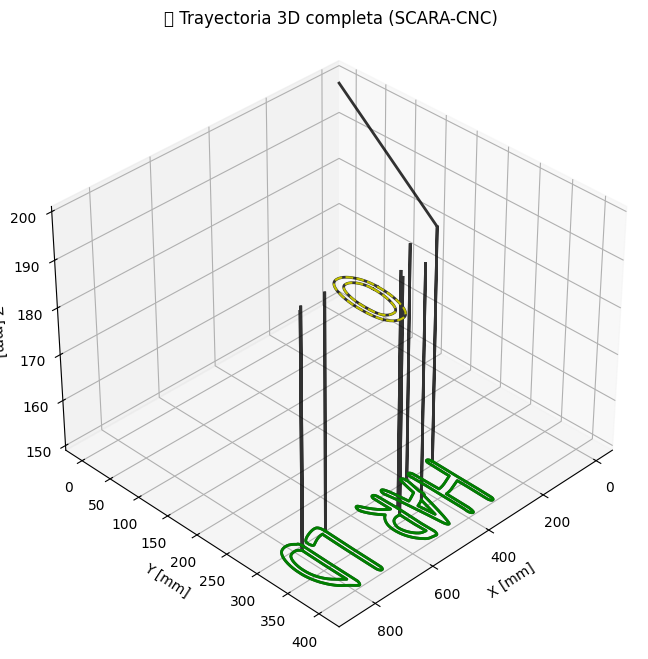

✅ Trayectoria 3D exportada: trayectoria_SCARA_3D.txt


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# =============================================================
# 🦾 CONVERSOR DXF → TRAYECTORIA 3D SCARA-CNC (topología + color)
# Harold & Abril · versión 3D final · 2025
# =============================================================

!pip install ezdxf shapely matplotlib numpy scipy scikit-learn --quiet

import ezdxf
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import LineString
from shapely.ops import linemerge, unary_union
from scipy.interpolate import splprep, splev
from sklearn.cluster import DBSCAN
from google.colab import files
from mpl_toolkits.mplot3d import Axes3D

# -------------------------------------------------------------
# 1️⃣ SUBIR ARCHIVO DXF
# -------------------------------------------------------------
print("📂 Sube el archivo DXF que deseas procesar:")
uploaded = files.upload()
dxf_file = list(uploaded.keys())[0]
print(f"✅ Archivo cargado: {dxf_file}")

# -------------------------------------------------------------
# 2️⃣ PARÁMETROS SCARA
# -------------------------------------------------------------
Z_guardado = float(input("Altura Z_guardado [mm]: ") or 200)
Z_corte     = float(input("Altura Z_corte [mm]: ") or 150)
print(f"🦾 Alturas: Z_guardado={Z_guardado} | Z_corte={Z_corte}")

# -------------------------------------------------------------
# 3️⃣ LECTOR DXF UNIVERSAL (XY + color robusto)
# -------------------------------------------------------------
doc = ezdxf.readfile(dxf_file)
msp = doc.modelspace()
geoms = []

def get_color_real(ent):
    """Devuelve el color real, considerando colorByLayer y truecolor RGB"""
    try:
        color = ent.dxf.color
        if color in (0, 256):  # por capa / por bloque
            layer_name = ent.dxf.layer
            layer = doc.layers.get(layer_name)
            color = layer.color
        # Detectar amarillo por truecolor
        if hasattr(ent.dxf, "rgb"):
            rgb = ent.rgb
            if rgb and isinstance(rgb, tuple) and rgb[0] > 200 and rgb[1] > 200 and rgb[2] < 100:
                return 2
        return color
    except:
        return 7

def procesar_entidad(e):
    dtype = e.dxftype()
    color = get_color_real(e)
    layer = e.dxf.layer
    puntos = []
    try:
        if dtype == "LINE":
            start, end = e.dxf.start, e.dxf.end
            puntos = [[start.x, start.y], [end.x, end.y]]
        elif dtype == "LWPOLYLINE":
            pts = np.array(e.get_points())[:, :2]
            puntos = pts
        elif dtype == "POLYLINE":
            pts = [v.dxf.location[:2] for v in e.vertices]
            puntos = np.array(pts)
        elif dtype == "CIRCLE":
            c, r = e.dxf.center, e.dxf.radius
            t = np.linspace(0, 2*np.pi, 200)
            puntos = np.column_stack([c.x + r*np.cos(t), c.y + r*np.sin(t)])
        elif dtype == "ARC":
            c, r = e.dxf.center, e.dxf.radius
            a1, a2 = np.deg2rad(e.dxf.start_angle), np.deg2rad(e.dxf.end_angle)
            t = np.linspace(a1, a2, 120)
            puntos = np.column_stack([c.x + r*np.cos(t), c.y + r*np.sin(t)])
        elif dtype == "SPLINE":
            fit = np.array(e.fit_points)
            if len(fit) >= 2:
                tck, _ = splprep([fit[:,0], fit[:,1]], s=0)
                u = np.linspace(0, 1, 200)
                x, y = splev(u, tck)
                puntos = np.column_stack([x, y])
            else:
                ctrl = np.array(e.control_points)
                if len(ctrl) >= 2:
                    tck, _ = splprep([ctrl[:,0], ctrl[:,1]], s=0)
                    u = np.linspace(0, 1, 200)
                    x, y = splev(u, tck)
                    puntos = np.column_stack([x, y])
        if len(puntos) > 1:
            geoms.append({"geom": LineString(puntos), "color": color, "layer": layer})
    except Exception as ex:
        print(f"⚠️ No se pudo procesar {dtype}: {ex}")

for e in msp:
    procesar_entidad(e)

if not geoms:
    raise ValueError("⚠️ No se detectaron entidades válidas en el DXF.")

# -------------------------------------------------------------
# 4️⃣ CLASIFICAR POR COLOR (CORTAR / NO CORTAR)
# -------------------------------------------------------------
def clasificar_color(color, layer):
    if color == 2 or "NO" in layer.upper():
        return "NO_CORTAR"
    else:
        return "CORTAR"

geoms_cortar = [g["geom"] for g in geoms if clasificar_color(g["color"], g["layer"]) == "CORTAR"]
geoms_nocortar = [g["geom"] for g in geoms if clasificar_color(g["color"], g["layer"]) == "NO_CORTAR"]

print(f"✂️ Figuras a cortar: {len(geoms_cortar)}")
print(f"🚫 Figuras NO cortar: {len(geoms_nocortar)}")

# -------------------------------------------------------------
# 5️⃣ UNIÓN TOPOLOGICA (DBSCAN + UNION)
# -------------------------------------------------------------
def unir_topologicamente(geoms, tolerancia=0.05):
    if not geoms:
        return []
    endpoints = []
    for gi, g in enumerate(geoms):
        coords = list(g.coords)
        endpoints.append(coords[0])
        endpoints.append(coords[-1])
    endpoints = np.array(endpoints)
    labels = DBSCAN(eps=tolerancia, min_samples=1).fit_predict(endpoints)
    n_clusters = labels.max() + 1
    centroids = np.zeros((n_clusters, 2))
    for k in range(n_clusters):
        pts = endpoints[labels == k]
        centroids[k] = pts.mean(axis=0)
    geoms_sanitized = []
    for gi, g in enumerate(geoms):
        coords = list(g.coords)
        label_start = labels[2*gi]
        label_end = labels[2*gi + 1]
        coords[0] = tuple(centroids[label_start])
        coords[-1] = tuple(centroids[label_end])
        geoms_sanitized.append(LineString(coords))
    union = unary_union(geoms_sanitized)
    merged = linemerge(union)
    return [merged] if isinstance(merged, LineString) else list(merged.geoms)

merged_cortar = unir_topologicamente(geoms_cortar)
merged_nocortar = unir_topologicamente(geoms_nocortar)

print(f"✅ Trayectorias finales: cortar = {len(merged_cortar)}, no cortar = {len(merged_nocortar)}")

# -------------------------------------------------------------
# 6️⃣ CONSTRUIR TRAYECTORIA 3D COMPLETA
# -------------------------------------------------------------
trayectoria_3D = []
trayectoria_3D.append(np.array([[0, 0, Z_guardado, 1]]))  # punto inicial con columna CORTAR=1

for grupo in merged_cortar:
    x, y = grupo.xy
    inicio = np.array([[x[0], y[0], Z_guardado, 1]])
    desc = np.array([[x[0], y[0], Z_corte, 1]])
    corte = np.column_stack([x, y, np.ones_like(x)*Z_corte, np.ones_like(x)])
    sube = np.array([[x[-1], y[-1], Z_guardado, 1]])
    trayectoria_3D.append(np.vstack([inicio, desc, corte, sube, np.full((1,4), np.nan)]))

for grupo in merged_nocortar:
    x, y = grupo.xy
    z = np.ones_like(x) * Z_guardado
    nc = np.zeros_like(x)  # bandera NO_CORTAR = 0
    corte = np.column_stack([x, y, z, nc])
    trayectoria_3D.append(np.vstack([corte, np.full((1,4), np.nan)]))

# Final: regresar al home
trayectoria_3D.append(np.array([[0, 0, Z_guardado, 1]]))
trayectoria_total = np.vstack(trayectoria_3D)

print(f"📈 Total de puntos en trayectoria 3D: {np.sum(~np.isnan(trayectoria_total[:,0]))}")

# -------------------------------------------------------------
# 7️⃣ GRAFICAR 3D
# -------------------------------------------------------------
fig = plt.figure(figsize=(9,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(trayectoria_total[:,0], trayectoria_total[:,1], trayectoria_total[:,2], 'k-', linewidth=2, alpha=0.8)

for g in merged_cortar:
    x, y = g.xy
    z = np.ones_like(x) * Z_corte
    ax.plot(x, y, z, 'g-', linewidth=2)

for g in merged_nocortar:
    x, y = g.xy
    z = np.ones_like(x) * Z_guardado
    ax.plot(x, y, z, 'y--', linewidth=1.5)

ax.set_title("🦾 Trayectoria 3D completa (SCARA-CNC)")
ax.set_xlabel("X [mm]")
ax.set_ylabel("Y [mm]")
ax.set_zlabel("Z [mm]")
ax.view_init(elev=35, azim=45)
plt.show()

# -------------------------------------------------------------
# 8️⃣ EXPORTAR TXT 3D (con columna CORTAR)
# -------------------------------------------------------------
nombre_txt = "trayectoria_SCARA_3D.txt"
with open(nombre_txt, 'w') as f:
    f.write("X Y Z CORTAR\n")
    for x, y, z, c in trayectoria_total:
        if np.isnan(x):
            f.write("NaN NaN NaN NaN\n")
        else:
            f.write(f"{x:.6f} {y:.6f} {z:.6f} {int(c)}\n")
print(f"✅ Trayectoria 3D exportada: {nombre_txt}")
files.download(nombre_txt)


📂 Sube el archivo DXF que deseas procesar:


Saving logo7-new.dxf to logo7-new (36).dxf
✅ Archivo cargado: logo7-new (36).dxf
Altura Z_guardado [mm]: 200
Altura Z_corte [mm]: 150
🦾 Alturas: Z_guardado=200.0 | Z_corte=150.0
✂️ Figuras a cortar: 114
🚫 Figuras NO cortar: 16
✅ Trayectorias finales: cortar = 8, no cortar = 2
📈 Total de puntos en trayectoria 3D: 21352


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129470 (\N{MECHANICAL ARM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


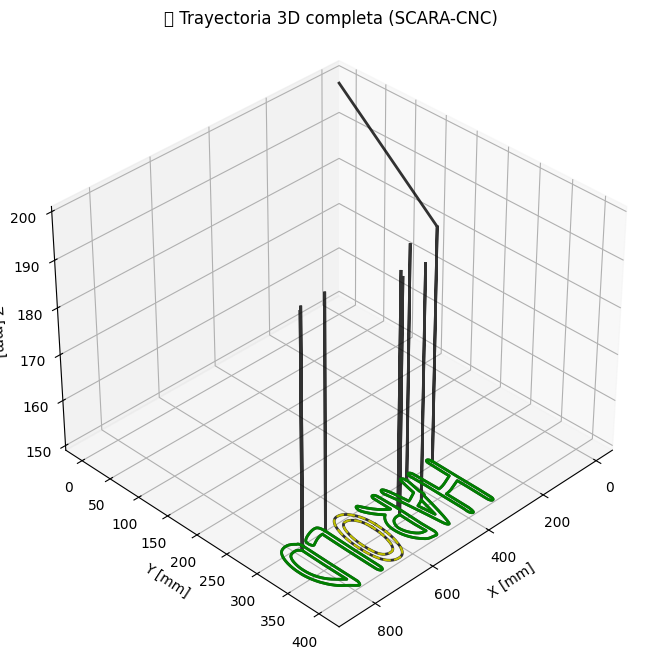

✅ Trayectoria 3D exportada: trayectoria_SCARA_3D.txt


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# =============================================================
# 🦾 CONVERSOR DXF → TRAYECTORIA 3D SCARA-CNC (topología + color)
# Harold & Abril · versión 3D final · 2025
# -------------------------------------------------------------

!pip install ezdxf shapely matplotlib numpy scipy scikit-learn --quiet

import ezdxf
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import LineString
from shapely.ops import linemerge, unary_union
from scipy.interpolate import splprep, splev
from sklearn.cluster import DBSCAN
from google.colab import files
from mpl_toolkits.mplot3d import Axes3D

# -------------------------------------------------------------
# 1️⃣ SUBIR ARCHIVO DXF
# -------------------------------------------------------------
print("📂 Sube el archivo DXF que deseas procesar:")
uploaded = files.upload()
dxf_file = list(uploaded.keys())[0]
print(f"✅ Archivo cargado: {dxf_file}")

# -------------------------------------------------------------
# 2️⃣ PARÁMETROS SCARA
# -------------------------------------------------------------
Z_guardado = float(input("Altura Z_guardado [mm]: ") or 200)
Z_corte     = float(input("Altura Z_corte [mm]: ") or 150)
print(f"🦾 Alturas: Z_guardado={Z_guardado} | Z_corte={Z_corte}")

# -------------------------------------------------------------
# 3️⃣ LECTOR DXF UNIVERSAL (XY + color robusto)
# -------------------------------------------------------------
doc = ezdxf.readfile(dxf_file)
msp = doc.modelspace()
geoms = []

def get_color_real(ent):
    """Devuelve el color real, considerando colorByLayer y truecolor RGB"""
    try:
        color = ent.dxf.color
        if color in (0, 256):
            layer_name = ent.dxf.layer
            layer = doc.layers.get(layer_name)
            color = layer.color
        if hasattr(ent.dxf, "rgb"):
            rgb = ent.rgb
            if rgb and isinstance(rgb, tuple) and rgb[0] > 200 and rgb[1] > 200 and rgb[2] < 100:
                return 2
        return color
    except:
        return 7

def procesar_entidad(e):
    dtype = e.dxftype()
    color = get_color_real(e)
    layer = e.dxf.layer
    puntos = []
    try:
        if dtype == "LINE":
            start, end = e.dxf.start, e.dxf.end
            puntos = [[start.x, start.y], [end.x, end.y]]
        elif dtype == "LWPOLYLINE":
            pts = np.array(e.get_points())[:, :2]
            puntos = pts
        elif dtype == "POLYLINE":
            pts = [v.dxf.location[:2] for v in e.vertices]
            puntos = np.array(pts)
        elif dtype == "CIRCLE":
            c, r = e.dxf.center, e.dxf.radius
            t = np.linspace(0, 2*np.pi, 200)
            puntos = np.column_stack([c.x + r*np.cos(t), c.y + r*np.sin(t)])
        elif dtype == "ARC":
            c, r = e.dxf.center, e.dxf.radius
            a1, a2 = np.deg2rad(e.dxf.start_angle), np.deg2rad(e.dxf.end_angle)
            t = np.linspace(a1, a2, 120)
            puntos = np.column_stack([c.x + r*np.cos(t), c.y + r*np.sin(t)])
        elif dtype == "SPLINE":
            fit = np.array(e.fit_points)
            if len(fit) >= 2:
                tck, _ = splprep([fit[:,0], fit[:,1]], s=0)
                u = np.linspace(0, 1, 200)
                x, y = splev(u, tck)
                puntos = np.column_stack([x, y])
            else:
                ctrl = np.array(e.control_points)
                if len(ctrl) >= 2:
                    tck, _ = splprep([ctrl[:,0], ctrl[:,1]], s=0)
                    u = np.linspace(0, 1, 200)
                    x, y = splev(u, tck)
                    puntos = np.column_stack([x, y])
        if len(puntos) > 1:
            geoms.append({"geom": LineString(puntos), "color": color, "layer": layer})
    except Exception as ex:
        print(f"⚠️ No se pudo procesar {dtype}: {ex}")

for e in msp:
    procesar_entidad(e)

if not geoms:
    raise ValueError("⚠️ No se detectaron entidades válidas en el DXF.")

# -------------------------------------------------------------
# 4️⃣ CLASIFICAR POR COLOR (CORTAR / NO CORTAR)
# -------------------------------------------------------------
def clasificar_color(color, layer):
    if color == 2 or "NO" in layer.upper():
        return "NO_CORTAR"
    else:
        return "CORTAR"

geoms_cortar = [g["geom"] for g in geoms if clasificar_color(g["color"], g["layer"]) == "CORTAR"]
geoms_nocortar = [g["geom"] for g in geoms if clasificar_color(g["color"], g["layer"]) == "NO_CORTAR"]

print(f"✂️ Figuras a cortar: {len(geoms_cortar)}")
print(f"🚫 Figuras NO cortar: {len(geoms_nocortar)}")

# -------------------------------------------------------------
# 5️⃣ UNIÓN TOPOLOGICA (DBSCAN + UNION)
# -------------------------------------------------------------
def unir_topologicamente(geoms, tolerancia=0.05):
    if not geoms:
        return []
    endpoints = []
    for gi, g in enumerate(geoms):
        coords = list(g.coords)
        endpoints.append(coords[0])
        endpoints.append(coords[-1])
    endpoints = np.array(endpoints)
    labels = DBSCAN(eps=tolerancia, min_samples=1).fit_predict(endpoints)
    n_clusters = labels.max() + 1
    centroids = np.zeros((n_clusters, 2))
    for k in range(n_clusters):
        pts = endpoints[labels == k]
        centroids[k] = pts.mean(axis=0)
    geoms_sanitized = []
    for gi, g in enumerate(geoms):
        coords = list(g.coords)
        label_start = labels[2*gi]
        label_end = labels[2*gi + 1]
        coords[0] = tuple(centroids[label_start])
        coords[-1] = tuple(centroids[label_end])
        geoms_sanitized.append(LineString(coords))
    union = unary_union(geoms_sanitized)
    merged = linemerge(union)
    return [merged] if isinstance(merged, LineString) else list(merged.geoms)

merged_cortar = unir_topologicamente(geoms_cortar)
merged_nocortar = unir_topologicamente(geoms_nocortar)

print(f"✅ Trayectorias finales: cortar = {len(merged_cortar)}, no cortar = {len(merged_nocortar)}")

# -------------------------------------------------------------
# 6️⃣ CONSTRUIR TRAYECTORIA 3D COMPLETA
# -------------------------------------------------------------
trayectoria_3D = []
trayectoria_3D.append(np.array([[0, 0, Z_guardado, 1]]))  # punto inicial

# CORTAR
for grupo in merged_cortar:
    x, y = grupo.xy
    inicio = np.array([[x[0], y[0], Z_guardado, 1]])
    desc = np.array([[x[0], y[0], Z_corte, 1]])
    corte = np.column_stack([x, y, np.ones_like(x)*Z_corte, np.ones_like(x)])
    sube = np.array([[x[-1], y[-1], Z_guardado, 1]])
    trayectoria_3D.append(np.vstack([inicio, desc, corte, sube, np.full((1,4), np.nan)]))

# NO_CORTAR → ahora dibujado en Z_corte
for grupo in merged_nocortar:
    x, y = grupo.xy
    z = np.ones_like(x) * Z_corte
    nc = np.zeros_like(x)  # bandera NO_CORTAR = 0
    corte = np.column_stack([x, y, z, nc])
    trayectoria_3D.append(np.vstack([corte, np.full((1,4), np.nan)]))

# Final: regresar al home
trayectoria_3D.append(np.array([[0, 0, Z_guardado, 1]]))
trayectoria_total = np.vstack(trayectoria_3D)

print(f"📈 Total de puntos en trayectoria 3D: {np.sum(~np.isnan(trayectoria_total[:,0]))}")

# -------------------------------------------------------------
# 7️⃣ GRAFICAR 3D
# -------------------------------------------------------------
fig = plt.figure(figsize=(9,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(trayectoria_total[:,0], trayectoria_total[:,1], trayectoria_total[:,2], 'k-', linewidth=2, alpha=0.8)

for g in merged_cortar:
    x, y = g.xy
    z = np.ones_like(x) * Z_corte
    ax.plot(x, y, z, 'g-', linewidth=2)

for g in merged_nocortar:
    x, y = g.xy
    z = np.ones_like(x) * Z_corte  # ahora Z_corte
    ax.plot(x, y, z, 'y--', linewidth=1.5)

ax.set_title("🦾 Trayectoria 3D completa (SCARA-CNC)")
ax.set_xlabel("X [mm]")
ax.set_ylabel("Y [mm]")
ax.set_zlabel("Z [mm]")
ax.view_init(elev=35, azim=45)
plt.show()

# -------------------------------------------------------------
# 8️⃣ EXPORTAR TXT 3D (con columna CORTAR)
# -------------------------------------------------------------
nombre_txt = "trayectoria_SCARA_3D.txt"
with open(nombre_txt, 'w') as f:
    f.write("X Y Z CORTAR\n")
    for x, y, z, c in trayectoria_total:
        if np.isnan(x):
            f.write("NaN NaN NaN NaN\n")
        else:
            f.write(f"{x:.6f} {y:.6f} {z:.6f} {int(c)}\n")
print(f"✅ Trayectoria 3D exportada: {nombre_txt}")
files.download(nombre_txt)


📂 Sube el archivo DXF que deseas procesar:


Saving logo7-new.dxf to logo7-new (37).dxf
✅ Archivo cargado: logo7-new (37).dxf
Altura Z_guardado [mm]: 200
Altura Z_corte [mm]: 150
🦾 Alturas: Z_guardado=200.0 | Z_corte=150.0
✂️ Figuras a cortar: 114
🚫 Figuras NO cortar: 16
✅ Trayectorias finales: cortar = 8, no cortar = 2
📈 Total de puntos en trayectoria 3D: 23197


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129470 (\N{MECHANICAL ARM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


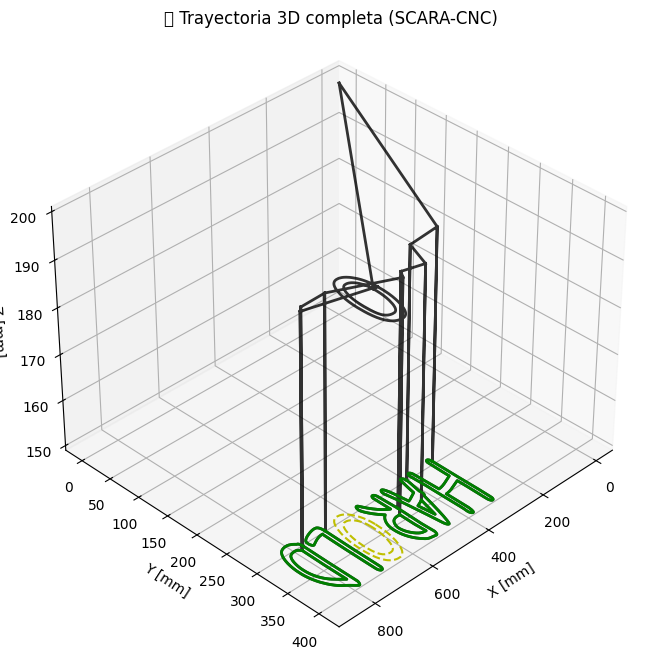

✅ Trayectoria 3D exportada: trayectoria_SCARA_3D.txt


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# =============================================================
# 🦾 CONVERSOR DXF → TRAYECTORIA 3D SCARA-CNC (topología + color)
# Harold & Abril · versión 3D final · 2025
# -------------------------------------------------------------

!pip install ezdxf shapely matplotlib numpy scipy scikit-learn --quiet

import ezdxf
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import LineString
from shapely.ops import linemerge, unary_union
from scipy.interpolate import splprep, splev
from sklearn.cluster import DBSCAN
from google.colab import files
from mpl_toolkits.mplot3d import Axes3D

# -------------------------------------------------------------
# 1️⃣ SUBIR ARCHIVO DXF
# -------------------------------------------------------------
print("📂 Sube el archivo DXF que deseas procesar:")
uploaded = files.upload()
dxf_file = list(uploaded.keys())[0]
print(f"✅ Archivo cargado: {dxf_file}")

# -------------------------------------------------------------
# 2️⃣ PARÁMETROS SCARA
# -------------------------------------------------------------
Z_guardado = float(input("Altura Z_guardado [mm]: ") or 200)
Z_corte     = float(input("Altura Z_corte [mm]: ") or 150)
print(f"🦾 Alturas: Z_guardado={Z_guardado} | Z_corte={Z_corte}")

# -------------------------------------------------------------
# 3️⃣ LECTOR DXF UNIVERSAL (XY + color robusto)
# -------------------------------------------------------------
doc = ezdxf.readfile(dxf_file)
msp = doc.modelspace()
geoms = []

def get_color_real(ent):
    """Devuelve el color real, considerando colorByLayer y truecolor RGB"""
    try:
        color = ent.dxf.color
        if color in (0, 256):
            layer_name = ent.dxf.layer
            layer = doc.layers.get(layer_name)
            color = layer.color
        if hasattr(ent.dxf, "rgb"):
            rgb = ent.rgb
            if rgb and isinstance(rgb, tuple) and rgb[0] > 200 and rgb[1] > 200 and rgb[2] < 100:
                return 2
        return color
    except:
        return 7

def procesar_entidad(e):
    dtype = e.dxftype()
    color = get_color_real(e)
    layer = e.dxf.layer
    puntos = []
    try:
        if dtype == "LINE":
            start, end = e.dxf.start, e.dxf.end
            puntos = [[start.x, start.y], [end.x, end.y]]
        elif dtype == "LWPOLYLINE":
            pts = np.array(e.get_points())[:, :2]
            puntos = pts
        elif dtype == "POLYLINE":
            pts = [v.dxf.location[:2] for v in e.vertices]
            puntos = np.array(pts)
        elif dtype == "CIRCLE":
            c, r = e.dxf.center, e.dxf.radius
            t = np.linspace(0, 2*np.pi, 200)
            puntos = np.column_stack([c.x + r*np.cos(t), c.y + r*np.sin(t)])
        elif dtype == "ARC":
            c, r = e.dxf.center, e.dxf.radius
            a1, a2 = np.deg2rad(e.dxf.start_angle), np.deg2rad(e.dxf.end_angle)
            t = np.linspace(a1, a2, 120)
            puntos = np.column_stack([c.x + r*np.cos(t), c.y + r*np.sin(t)])
        elif dtype == "SPLINE":
            fit = np.array(e.fit_points)
            if len(fit) >= 2:
                tck, _ = splprep([fit[:,0], fit[:,1]], s=0)
                u = np.linspace(0, 1, 200)
                x, y = splev(u, tck)
                puntos = np.column_stack([x, y])
            else:
                ctrl = np.array(e.control_points)
                if len(ctrl) >= 2:
                    tck, _ = splprep([ctrl[:,0], ctrl[:,1]], s=0)
                    u = np.linspace(0, 1, 200)
                    x, y = splev(u, tck)
                    puntos = np.column_stack([x, y])
        if len(puntos) > 1:
            geoms.append({"geom": LineString(puntos), "color": color, "layer": layer})
    except Exception as ex:
        print(f"⚠️ No se pudo procesar {dtype}: {ex}")

for e in msp:
    procesar_entidad(e)

if not geoms:
    raise ValueError("⚠️ No se detectaron entidades válidas en el DXF.")

# -------------------------------------------------------------
# 4️⃣ CLASIFICAR POR COLOR (CORTAR / NO CORTAR)
# -------------------------------------------------------------
def clasificar_color(color, layer):
    if color == 2 or "NO" in layer.upper():
        return "NO_CORTAR"
    else:
        return "CORTAR"

geoms_cortar = [g["geom"] for g in geoms if clasificar_color(g["color"], g["layer"]) == "CORTAR"]
geoms_nocortar = [g["geom"] for g in geoms if clasificar_color(g["color"], g["layer"]) == "NO_CORTAR"]

print(f"✂️ Figuras a cortar: {len(geoms_cortar)}")
print(f"🚫 Figuras NO cortar: {len(geoms_nocortar)}")

# -------------------------------------------------------------
# 5️⃣ UNIÓN TOPOLOGICA (DBSCAN + UNION)
# -------------------------------------------------------------
def unir_topologicamente(geoms, tolerancia=0.05):
    if not geoms:
        return []
    endpoints = []
    for gi, g in enumerate(geoms):
        coords = list(g.coords)
        endpoints.append(coords[0])
        endpoints.append(coords[-1])
    endpoints = np.array(endpoints)
    labels = DBSCAN(eps=tolerancia, min_samples=1).fit_predict(endpoints)
    n_clusters = labels.max() + 1
    centroids = np.zeros((n_clusters, 2))
    for k in range(n_clusters):
        pts = endpoints[labels == k]
        centroids[k] = pts.mean(axis=0)
    geoms_sanitized = []
    for gi, g in enumerate(geoms):
        coords = list(g.coords)
        label_start = labels[2*gi]
        label_end = labels[2*gi + 1]
        coords[0] = tuple(centroids[label_start])
        coords[-1] = tuple(centroids[label_end])
        geoms_sanitized.append(LineString(coords))
    union = unary_union(geoms_sanitized)
    merged = linemerge(union)
    return [merged] if isinstance(merged, LineString) else list(merged.geoms)

merged_cortar = unir_topologicamente(geoms_cortar)
merged_nocortar = unir_topologicamente(geoms_nocortar)

print(f"✅ Trayectorias finales: cortar = {len(merged_cortar)}, no cortar = {len(merged_nocortar)}")

# -------------------------------------------------------------
# 6️⃣ CONSTRUIR TRAYECTORIA 3D COMPLETA (con interpolación entre bloques)
# -------------------------------------------------------------
def interpolar_linea(p1, p2, paso=1.0):
    """Genera puntos interpolados en línea recta entre p1 y p2 a altura constante Z_guardado"""
    distancia = np.linalg.norm(p2[:2] - p1[:2])
    if distancia < 1e-6:
        return np.array([p1])
    n_pts = max(int(distancia/paso), 2)
    line = np.linspace(p1, p2, n_pts)
    return line

trayectoria_3D = []
trayectoria_3D.append(np.array([[0, 0, Z_guardado, 1]]))  # punto inicial
ultimo_punto_guardado = np.array([0,0,Z_guardado,1])

def agregar_grupo(x, y, cortar_flag):
    global ultimo_punto_guardado
    # Interpolar desde el último punto guardado al inicio del grupo
    inicio_grupo_guardado = np.array([x[0], y[0], Z_guardado, cortar_flag])
    interp = interpolar_linea(ultimo_punto_guardado, inicio_grupo_guardado)
    # Bajada a Z_corte si es CORTAR
    if cortar_flag == 1:
        desc = np.array([[x[0], y[0], Z_corte, 1]])
    else:
        desc = np.array([[x[0], y[0], Z_guardado, 0]])
    corte = np.column_stack([x, y, np.ones_like(x)*(Z_corte if cortar_flag==1 else Z_guardado), np.ones_like(x)*cortar_flag])
    sube = np.array([[x[-1], y[-1], Z_guardado, cortar_flag]])
    ultimo_punto_guardado = sube[0]
    return np.vstack([interp, desc, corte, sube, np.full((1,4), np.nan)])

# CORTAR
for grupo in merged_cortar:
    x, y = grupo.xy
    trayectoria_3D.append(agregar_grupo(x, y, 1))

# NO_CORTAR → dibujado en Z_corte
for grupo in merged_nocortar:
    x, y = grupo.xy
    trayectoria_3D.append(agregar_grupo(x, y, 0))

# Final: regresar al home
interp_final = interpolar_linea(ultimo_punto_guardado, np.array([0,0,Z_guardado,1]))
trayectoria_3D.append(interp_final)

trayectoria_total = np.vstack(trayectoria_3D)
print(f"📈 Total de puntos en trayectoria 3D: {np.sum(~np.isnan(trayectoria_total[:,0]))}")

# -------------------------------------------------------------
# 7️⃣ GRAFICAR 3D
# -------------------------------------------------------------
fig = plt.figure(figsize=(9,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(trayectoria_total[:,0], trayectoria_total[:,1], trayectoria_total[:,2], 'k-', linewidth=2, alpha=0.8)

for g in merged_cortar:
    x, y = g.xy
    z = np.ones_like(x) * Z_corte
    ax.plot(x, y, z, 'g-', linewidth=2)

for g in merged_nocortar:
    x, y = g.xy
    z = np.ones_like(x) * Z_corte
    ax.plot(x, y, z, 'y--', linewidth=1.5)

ax.set_title("🦾 Trayectoria 3D completa (SCARA-CNC)")
ax.set_xlabel("X [mm]")
ax.set_ylabel("Y [mm]")
ax.set_zlabel("Z [mm]")
ax.view_init(elev=35, azim=45)
plt.show()

# -------------------------------------------------------------
# 8️⃣ EXPORTAR TXT 3D (con columna CORTAR)
# -------------------------------------------------------------
nombre_txt = "trayectoria_SCARA_3D.txt"
with open(nombre_txt, 'w') as f:
    f.write("X Y Z CORTAR\n")
    for x, y, z, c in trayectoria_total:
        if np.isnan(x):
            f.write("NaN NaN NaN NaN\n")
        else:
            f.write(f"{x:.6f} {y:.6f} {z:.6f} {int(c)}\n")
print(f"✅ Trayectoria 3D exportada: {nombre_txt}")
files.download(nombre_txt)


📂 Sube el archivo DXF que deseas procesar:


Saving logo7-new.dxf to logo7-new (39).dxf
✅ Archivo cargado: logo7-new (39).dxf
Altura Z_guardado [mm]: 200
Altura Z_corte [mm]: 150
🦾 Alturas: Z_guardado=200.0 | Z_corte=150.0
✂️ Figuras a cortar: 114
🚫 Figuras NO cortar: 16
✅ Trayectorias finales: cortar = 8, no cortar = 2
📈 Total de puntos en trayectoria 3D: 23137


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129470 (\N{MECHANICAL ARM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


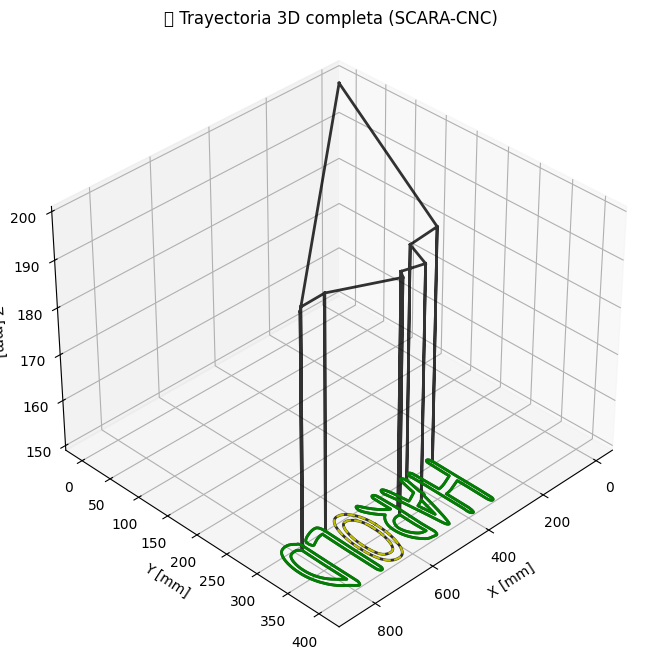

✅ Trayectoria 3D exportada: trayectoria_SCARA_3D.txt


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# =============================================================
# 🦾 CONVERSOR DXF → TRAYECTORIA 3D SCARA-CNC (topología + color)
# Harold & Abril · versión 3D final · 2025
# -------------------------------------------------------------

!pip install ezdxf shapely matplotlib numpy scipy scikit-learn --quiet

import ezdxf
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import LineString
from shapely.ops import linemerge, unary_union
from scipy.interpolate import splprep, splev
from sklearn.cluster import DBSCAN
from google.colab import files
from mpl_toolkits.mplot3d import Axes3D

# -------------------------------------------------------------
# 1️⃣ SUBIR ARCHIVO DXF
# -------------------------------------------------------------
print("📂 Sube el archivo DXF que deseas procesar:")
uploaded = files.upload()
dxf_file = list(uploaded.keys())[0]
print(f"✅ Archivo cargado: {dxf_file}")

# -------------------------------------------------------------
# 2️⃣ PARÁMETROS SCARA
# -------------------------------------------------------------
Z_guardado = float(input("Altura Z_guardado [mm]: ") or 200)
Z_corte     = float(input("Altura Z_corte [mm]: ") or 150)
print(f"🦾 Alturas: Z_guardado={Z_guardado} | Z_corte={Z_corte}")

# -------------------------------------------------------------
# 3️⃣ LECTOR DXF UNIVERSAL (XY + color robusto)
# -------------------------------------------------------------
doc = ezdxf.readfile(dxf_file)
msp = doc.modelspace()
geoms = []

def get_color_real(ent):
    try:
        color = ent.dxf.color
        if color in (0, 256):
            layer_name = ent.dxf.layer
            layer = doc.layers.get(layer_name)
            color = layer.color
        if hasattr(ent.dxf, "rgb"):
            rgb = ent.rgb
            if rgb and isinstance(rgb, tuple) and rgb[0] > 200 and rgb[1] > 200 and rgb[2] < 100:
                return 2
        return color
    except:
        return 7

def procesar_entidad(e):
    dtype = e.dxftype()
    color = get_color_real(e)
    layer = e.dxf.layer
    puntos = []
    try:
        if dtype == "LINE":
            start, end = e.dxf.start, e.dxf.end
            puntos = [[start.x, start.y], [end.x, end.y]]
        elif dtype == "LWPOLYLINE":
            pts = np.array(e.get_points())[:, :2]
            puntos = pts
        elif dtype == "POLYLINE":
            pts = [v.dxf.location[:2] for v in e.vertices]
            puntos = np.array(pts)
        elif dtype == "CIRCLE":
            c, r = e.dxf.center, e.dxf.radius
            t = np.linspace(0, 2*np.pi, 200)
            puntos = np.column_stack([c.x + r*np.cos(t), c.y + r*np.sin(t)])
        elif dtype == "ARC":
            c, r = e.dxf.center, e.dxf.radius
            a1, a2 = np.deg2rad(e.dxf.start_angle), np.deg2rad(e.dxf.end_angle)
            t = np.linspace(a1, a2, 120)
            puntos = np.column_stack([c.x + r*np.cos(t), c.y + r*np.sin(t)])
        elif dtype == "SPLINE":
            fit = np.array(e.fit_points)
            if len(fit) >= 2:
                tck, _ = splprep([fit[:,0], fit[:,1]], s=0)
                u = np.linspace(0, 1, 200)
                x, y = splev(u, tck)
                puntos = np.column_stack([x, y])
            else:
                ctrl = np.array(e.control_points)
                if len(ctrl) >= 2:
                    tck, _ = splprep([ctrl[:,0], ctrl[:,1]], s=0)
                    u = np.linspace(0, 1, 200)
                    x, y = splev(u, tck)
                    puntos = np.column_stack([x, y])
        if len(puntos) > 1:
            geoms.append({"geom": LineString(puntos), "color": color, "layer": layer})
    except Exception as ex:
        print(f"⚠️ No se pudo procesar {dtype}: {ex}")

for e in msp:
    procesar_entidad(e)

if not geoms:
    raise ValueError("⚠️ No se detectaron entidades válidas en el DXF.")

# -------------------------------------------------------------
# 4️⃣ CLASIFICAR POR COLOR (CORTAR / NO CORTAR)
# -------------------------------------------------------------
def clasificar_color(color, layer):
    if color == 2 or "NO" in layer.upper():
        return "NO_CORTAR"
    else:
        return "CORTAR"

geoms_cortar = [g["geom"] for g in geoms if clasificar_color(g["color"], g["layer"]) == "CORTAR"]
geoms_nocortar = [g["geom"] for g in geoms if clasificar_color(g["color"], g["layer"]) == "NO_CORTAR"]

print(f"✂️ Figuras a cortar: {len(geoms_cortar)}")
print(f"🚫 Figuras NO cortar: {len(geoms_nocortar)}")

# -------------------------------------------------------------
# 5️⃣ UNIÓN TOPOLOGICA (DBSCAN + UNION)
# -------------------------------------------------------------
def unir_topologicamente(geoms, tolerancia=0.05):
    if not geoms:
        return []
    endpoints = []
    for gi, g in enumerate(geoms):
        coords = list(g.coords)
        endpoints.append(coords[0])
        endpoints.append(coords[-1])
    endpoints = np.array(endpoints)
    labels = DBSCAN(eps=tolerancia, min_samples=1).fit_predict(endpoints)
    n_clusters = labels.max() + 1
    centroids = np.zeros((n_clusters, 2))
    for k in range(n_clusters):
        pts = endpoints[labels == k]
        centroids[k] = pts.mean(axis=0)
    geoms_sanitized = []
    for gi, g in enumerate(geoms):
        coords = list(g.coords)
        label_start = labels[2*gi]
        label_end = labels[2*gi + 1]
        coords[0] = tuple(centroids[label_start])
        coords[-1] = tuple(centroids[label_end])
        geoms_sanitized.append(LineString(coords))
    union = unary_union(geoms_sanitized)
    merged = linemerge(union)
    return [merged] if isinstance(merged, LineString) else list(merged.geoms)

merged_cortar = unir_topologicamente(geoms_cortar)
merged_nocortar = unir_topologicamente(geoms_nocortar)

print(f"✅ Trayectorias finales: cortar = {len(merged_cortar)}, no cortar = {len(merged_nocortar)}")

# -------------------------------------------------------------
# 6️⃣ CONSTRUIR TRAYECTORIA 3D COMPLETA (solo interpolar entre grupos CORTAR)
# -------------------------------------------------------------
def interpolar_linea(p1, p2, paso=1.0):
    distancia = np.linalg.norm(p2[:2] - p1[:2])
    if distancia < 1e-6:
        return np.array([p1])
    n_pts = max(int(distancia/paso), 2)
    line = np.linspace(p1, p2, n_pts)
    return line

trayectoria_3D = []
trayectoria_3D.append(np.array([[0, 0, Z_guardado, 1]]))
ultimo_punto_guardado = np.array([0,0,Z_guardado,1])

def agregar_grupo(x, y, cortar_flag):
    global ultimo_punto_guardado
    inicio_grupo_guardado = np.array([x[0], y[0], Z_guardado, cortar_flag])
    interp = interpolar_linea(ultimo_punto_guardado, inicio_grupo_guardado)
    if cortar_flag == 1:
        desc = np.array([[x[0], y[0], Z_corte, 1]])
    else:
        desc = np.array([[x[0], y[0], Z_guardado, 0]])
    corte = np.column_stack([x, y, np.ones_like(x)*(Z_corte if cortar_flag==1 else Z_guardado), np.ones_like(x)*cortar_flag])
    sube = np.array([[x[-1], y[-1], Z_guardado, cortar_flag]])
    ultimo_punto_guardado = sube[0]
    return np.vstack([interp, desc, corte, sube, np.full((1,4), np.nan)])

# 🟢 Solo procesar grupos CORTAR para saltos
for grupo in merged_cortar:
    x, y = grupo.xy
    trayectoria_3D.append(agregar_grupo(x, y, 1))

# 🔵 Procesar NO_CORTAR para dibujar sin afectar interpolación entre bloques
for grupo in merged_nocortar:
    x, y = grupo.xy
    corte = np.column_stack([x, y, np.ones_like(x)*Z_corte, np.zeros_like(x)])
    trayectoria_3D.append(np.vstack([corte, np.full((1,4), np.nan)]))

# Final: regresar al home
interp_final = interpolar_linea(ultimo_punto_guardado, np.array([0,0,Z_guardado,1]))
trayectoria_3D.append(interp_final)

trayectoria_total = np.vstack(trayectoria_3D)
print(f"📈 Total de puntos en trayectoria 3D: {np.sum(~np.isnan(trayectoria_total[:,0]))}")

# -------------------------------------------------------------
# 7️⃣ GRAFICAR 3D
# -------------------------------------------------------------
fig = plt.figure(figsize=(9,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(trayectoria_total[:,0], trayectoria_total[:,1], trayectoria_total[:,2], 'k-', linewidth=2, alpha=0.8)

for g in merged_cortar:
    x, y = g.xy
    z = np.ones_like(x) * Z_corte
    ax.plot(x, y, z, 'g-', linewidth=2)

for g in merged_nocortar:
    x, y = g.xy
    z = np.ones_like(x) * Z_corte
    ax.plot(x, y, z, 'y--', linewidth=1.5)

ax.set_title("🦾 Trayectoria 3D completa (SCARA-CNC)")
ax.set_xlabel("X [mm]")
ax.set_ylabel("Y [mm]")
ax.set_zlabel("Z [mm]")
ax.view_init(elev=35, azim=45)
plt.show()

# -------------------------------------------------------------
# 8️⃣ EXPORTAR TXT 3D (con columna CORTAR)
# -------------------------------------------------------------
nombre_txt = "trayectoria_SCARA_3D.txt"
with open(nombre_txt, 'w') as f:
    f.write("X Y Z CORTAR\n")
    for x, y, z, c in trayectoria_total:
        if np.isnan(x):
            f.write("NaN NaN NaN NaN\n")
        else:
            f.write(f"{x:.6f} {y:.6f} {z:.6f} {int(c)}\n")
print(f"✅ Trayectoria 3D exportada: {nombre_txt}")
files.download(nombre_txt)


📂 Sube el archivo DXF que deseas procesar:


Saving logo7-new.dxf to logo7-new (43).dxf
✅ Archivo cargado: logo7-new (43).dxf
Altura Z_guardado [mm] (default 200): 200
Altura Z_corte [mm] (default 150): 150
Velocidad de corte [mm/s] (default 20): 20
Velocidad de transición [mm/s] (default 80): 80
🦾 Alturas: Z_guardado=200.0 | Z_corte=150.0
⚡ Velocidad: Corte=20.0 mm/s | Transición=80.0 mm/s
✂️ Figuras a cortar: 114
🚫 Figuras NO cortar: 16
✅ Trayectorias finales: cortar = 8, no cortar = 2
📈 Total de puntos en trayectoria 3D: 23129


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129470 (\N{MECHANICAL ARM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


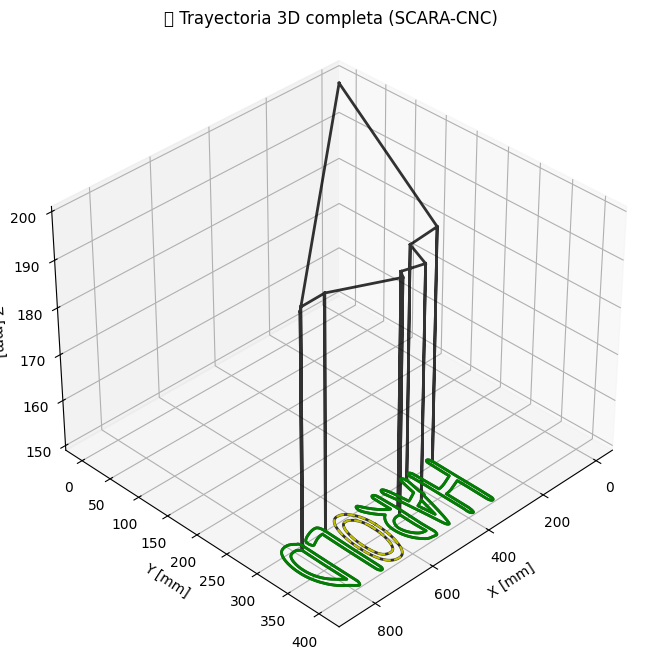

✅ Trayectoria 3D exportada con metadatos: trayectoria_SCARA_3D_velocidad.txt


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# =============================================================
# 🦾 CONVERSOR DXF → TRAYECTORIA 3D SCARA-CNC (topología + color + velocidad)
# Harold & Abril · versión 3D final corregida con velocidad y metadatos · 2025
# -------------------------------------------------------------

!pip install ezdxf shapely matplotlib numpy scipy scikit-learn --quiet

import ezdxf
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import LineString
from shapely.ops import linemerge, unary_union
from scipy.interpolate import splprep, splev
from sklearn.cluster import DBSCAN
from google.colab import files
from mpl_toolkits.mplot3d import Axes3D

# -------------------------------------------------------------
# 1️⃣ SUBIR ARCHIVO DXF
# -------------------------------------------------------------
print("📂 Sube el archivo DXF que deseas procesar:")
uploaded = files.upload()
dxf_file = list(uploaded.keys())[0]
print(f"✅ Archivo cargado: {dxf_file}")

# -------------------------------------------------------------
# 2️⃣ PARÁMETROS SCARA + VELOCIDADES
# -------------------------------------------------------------
Z_guardado = float(input("Altura Z_guardado [mm] (default 200): ") or 200)
Z_corte     = float(input("Altura Z_corte [mm] (default 150): ") or 150)
Velocidad_Corte      = float(input("Velocidad de corte [mm/s] (default 20): ") or 20)
Velocidad_Transicion = float(input("Velocidad de transición [mm/s] (default 80): ") or 80)

print(f"🦾 Alturas: Z_guardado={Z_guardado} | Z_corte={Z_corte}")
print(f"⚡ Velocidad: Corte={Velocidad_Corte} mm/s | Transición={Velocidad_Transicion} mm/s")

# -------------------------------------------------------------
# 3️⃣ LECTOR DXF UNIVERSAL (XY + color robusto)
# -------------------------------------------------------------
doc = ezdxf.readfile(dxf_file)
msp = doc.modelspace()
geoms = []

def get_color_real(ent):
    try:
        color = ent.dxf.color
        if color in (0, 256):
            layer_name = ent.dxf.layer
            layer = doc.layers.get(layer_name)
            color = layer.color
        if hasattr(ent.dxf, "rgb"):
            rgb = ent.rgb
            if rgb and isinstance(rgb, tuple) and rgb[0] > 200 and rgb[1] > 200 and rgb[2] < 100:
                return 2
        return color
    except:
        return 7

def procesar_entidad(e):
    dtype = e.dxftype()
    color = get_color_real(e)
    layer = e.dxf.layer
    puntos = []
    try:
        if dtype == "LINE":
            start, end = e.dxf.start, e.dxf.end
            puntos = [[start.x, start.y], [end.x, end.y]]
        elif dtype == "LWPOLYLINE":
            pts = np.array(e.get_points())[:, :2]
            puntos = pts
        elif dtype == "POLYLINE":
            pts = [v.dxf.location[:2] for v in e.vertices]
            puntos = np.array(pts)
        elif dtype == "CIRCLE":
            c, r = e.dxf.center, e.dxf.radius
            t = np.linspace(0, 2*np.pi, 200)
            puntos = np.column_stack([c.x + r*np.cos(t), c.y + r*np.sin(t)])
        elif dtype == "ARC":
            c, r = e.dxf.center, e.dxf.radius
            a1, a2 = np.deg2rad(e.dxf.start_angle), np.deg2rad(e.dxf.end_angle)
            t = np.linspace(a1, a2, 120)
            puntos = np.column_stack([c.x + r*np.cos(t), c.y + r*np.sin(t)])
        elif dtype == "SPLINE":
            fit = np.array(e.fit_points)
            if len(fit) >= 2:
                tck, _ = splprep([fit[:,0], fit[:,1]], s=0)
                u = np.linspace(0, 1, 200)
                x, y = splev(u, tck)
                puntos = np.column_stack([x, y])
            else:
                ctrl = np.array(e.control_points)
                if len(ctrl) >= 2:
                    tck, _ = splprep([ctrl[:,0], ctrl[:,1]], s=0)
                    u = np.linspace(0, 1, 200)
                    x, y = splev(u, tck)
                    puntos = np.column_stack([x, y])
        if len(puntos) > 1:
            geoms.append({"geom": LineString(puntos), "color": color, "layer": layer})
    except Exception as ex:
        print(f"⚠️ No se pudo procesar {dtype}: {ex}")

for e in msp:
    procesar_entidad(e)

if not geoms:
    raise ValueError("⚠️ No se detectaron entidades válidas en el DXF.")

# -------------------------------------------------------------
# 4️⃣ CLASIFICAR POR COLOR (CORTAR / NO CORTAR)
# -------------------------------------------------------------
def clasificar_color(color, layer):
    if color == 2 or "NO" in layer.upper():
        return "NO_CORTAR"
    else:
        return "CORTAR"

geoms_cortar = [g["geom"] for g in geoms if clasificar_color(g["color"], g["layer"]) == "CORTAR"]
geoms_nocortar = [g["geom"] for g in geoms if clasificar_color(g["color"], g["layer"]) == "NO_CORTAR"]

print(f"✂️ Figuras a cortar: {len(geoms_cortar)}")
print(f"🚫 Figuras NO cortar: {len(geoms_nocortar)}")

# -------------------------------------------------------------
# 5️⃣ UNIÓN TOPOLOGICA (DBSCAN + UNION)
# -------------------------------------------------------------
def unir_topologicamente(geoms, tolerancia=0.05):
    if not geoms:
        return []
    endpoints = []
    for gi, g in enumerate(geoms):
        coords = list(g.coords)
        endpoints.append(coords[0])
        endpoints.append(coords[-1])
    endpoints = np.array(endpoints)
    labels = DBSCAN(eps=tolerancia, min_samples=1).fit_predict(endpoints)
    n_clusters = labels.max() + 1
    centroids = np.zeros((n_clusters, 2))
    for k in range(n_clusters):
        pts = endpoints[labels == k]
        centroids[k] = pts.mean(axis=0)
    geoms_sanitized = []
    for gi, g in enumerate(geoms):
        coords = list(g.coords)
        label_start = labels[2*gi]
        label_end = labels[2*gi + 1]
        coords[0] = tuple(centroids[label_start])
        coords[-1] = tuple(centroids[label_end])
        geoms_sanitized.append(LineString(coords))
    union = unary_union(geoms_sanitized)
    merged = linemerge(union)
    return [merged] if isinstance(merged, LineString) else list(merged.geoms)

merged_cortar = unir_topologicamente(geoms_cortar)
merged_nocortar = unir_topologicamente(geoms_nocortar)

print(f"✅ Trayectorias finales: cortar = {len(merged_cortar)}, no cortar = {len(merged_nocortar)}")

# -------------------------------------------------------------
# 6️⃣ CONSTRUIR TRAYECTORIA 3D COMPLETA (sin puntos repetidos + velocidad)
# -------------------------------------------------------------
def interpolar_linea(p1, p2, paso=1.0):
    distancia = np.linalg.norm(p2[:2] - p1[:2])
    if distancia < 1e-6:
        return np.array([p1])
    n_pts = max(int(distancia/paso), 2)
    line = np.linspace(p1, p2, n_pts)
    return line

trayectoria_3D = []
trayectoria_3D.append(np.array([[0, 0, Z_guardado, 1, Velocidad_Transicion]]))
ultimo_punto_guardado = np.array([0,0,Z_guardado,1,Velocidad_Transicion])

def agregar_grupo(x, y, cortar_flag):
    global ultimo_punto_guardado
    trayectoria = []

    inicio_grupo_guardado = np.array([x[0], y[0], Z_guardado, cortar_flag,
                                      Velocidad_Transicion if cortar_flag==0 else Velocidad_Corte])
    if not np.allclose(ultimo_punto_guardado[:3], inicio_grupo_guardado[:3]):
        interp = interpolar_linea(ultimo_punto_guardado, inicio_grupo_guardado)
        trayectoria.append(interp)

    if cortar_flag == 1:
        desc = np.array([[x[0], y[0], Z_corte, 1, Velocidad_Corte]])
        if trayectoria and np.allclose(trayectoria[-1][-1][:3], desc[0][:3]):
            desc = np.empty((0,5))
        trayectoria.append(desc)

    velocidad_segmento = Velocidad_Corte if cortar_flag==1 else Velocidad_Transicion
    corte = np.column_stack([x, y, np.ones_like(x)*(Z_corte if cortar_flag==1 else Z_guardado),
                             np.ones_like(x)*cortar_flag, np.ones_like(x)*velocidad_segmento])
    if trayectoria and np.allclose(trayectoria[-1][-1][:3], corte[0][:3]):
        corte = corte[1:]
    trayectoria.append(corte)

    sube = np.array([[x[-1], y[-1], Z_guardado, cortar_flag, velocidad_segmento]])
    if np.allclose(trayectoria[-1][-1][:3], sube[0][:3]):
        sube = np.empty((0,5))
    trayectoria.append(sube)

    trayectoria.append(np.full((1,5), np.nan))

    ultimo_punto_guardado = np.array([x[-1], y[-1], Z_guardado, 1, Velocidad_Transicion])
    return np.vstack([t for t in trayectoria if t.size > 0])

for grupo in merged_cortar:
    x, y = grupo.xy
    trayectoria_3D.append(agregar_grupo(x, y, 1))

for grupo in merged_nocortar:
    x, y = grupo.xy
    velocidad_segmento = Velocidad_Transicion
    corte = np.column_stack([x, y, np.ones_like(x)*Z_corte, np.zeros_like(x), np.ones_like(x)*velocidad_segmento])
    trayectoria_3D.append(np.vstack([corte, np.full((1,5), np.nan)]))

interp_final = interpolar_linea(ultimo_punto_guardado, np.array([0,0,Z_guardado,1,Velocidad_Transicion]))
trayectoria_3D.append(interp_final)

trayectoria_total = np.vstack(trayectoria_3D)
print(f"📈 Total de puntos en trayectoria 3D: {np.sum(~np.isnan(trayectoria_total[:,0]))}")

# -------------------------------------------------------------
# 7️⃣ GRAFICAR 3D
# -------------------------------------------------------------
fig = plt.figure(figsize=(9,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(trayectoria_total[:,0], trayectoria_total[:,1], trayectoria_total[:,2], 'k-', linewidth=2, alpha=0.8)

for g in merged_cortar:
    x, y = g.xy
    z = np.ones_like(x) * Z_corte
    ax.plot(x, y, z, 'g-', linewidth=2)

for g in merged_nocortar:
    x, y = g.xy
    z = np.ones_like(x) * Z_corte
    ax.plot(x, y, z, 'y--', linewidth=1.5)

ax.set_title("🦾 Trayectoria 3D completa (SCARA-CNC)")
ax.set_xlabel("X [mm]")
ax.set_ylabel("Y [mm]")
ax.set_zlabel("Z [mm]")
ax.view_init(elev=35, azim=45)
plt.show()

# -------------------------------------------------------------
# 8️⃣ EXPORTAR TXT 3D (con columna CORTAR + VELOCIDAD + metadatos)
# -------------------------------------------------------------
nombre_txt = "trayectoria_SCARA_3D_velocidad.txt"
with open(nombre_txt, 'w') as f:
    f.write("# =============================================================\n")
    f.write("# 🦾 METADATOS DE TRAYECTORIA SCARA-CNC\n")
    f.write(f"# Z_guardado = {Z_guardado:.3f} [mm]\n")
    f.write(f"# Z_corte = {Z_corte:.3f} [mm]\n")
    f.write(f"# Velocidad_Corte = {Velocidad_Corte:.3f} [mm/s]\n")
    f.write(f"# Velocidad_Transicion = {Velocidad_Transicion:.3f} [mm/s]\n")
    f.write("# =============================================================\n")
    f.write("X Y Z CORTAR VELOCIDAD\n")

    for x, y, z, c, v in trayectoria_total:
        if np.isnan(x):
            f.write("NaN NaN NaN NaN NaN\n")
        else:
            f.write(f"{x:.6f} {y:.6f} {z:.6f} {int(c)} {v:.2f}\n")

print(f"✅ Trayectoria 3D exportada con metadatos: {nombre_txt}")
files.download(nombre_txt)


📂 Sube el archivo DXF que deseas procesar:


Saving PruebaCorte_especial.dxf to PruebaCorte_especial (2).dxf
✅ Archivo cargado: PruebaCorte_especial (2).dxf
✂️ Figuras a cortar: 248
🚫 Figuras NO cortar: 82
✅ Trayectorias finales: cortar = 25, no cortar = 9


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


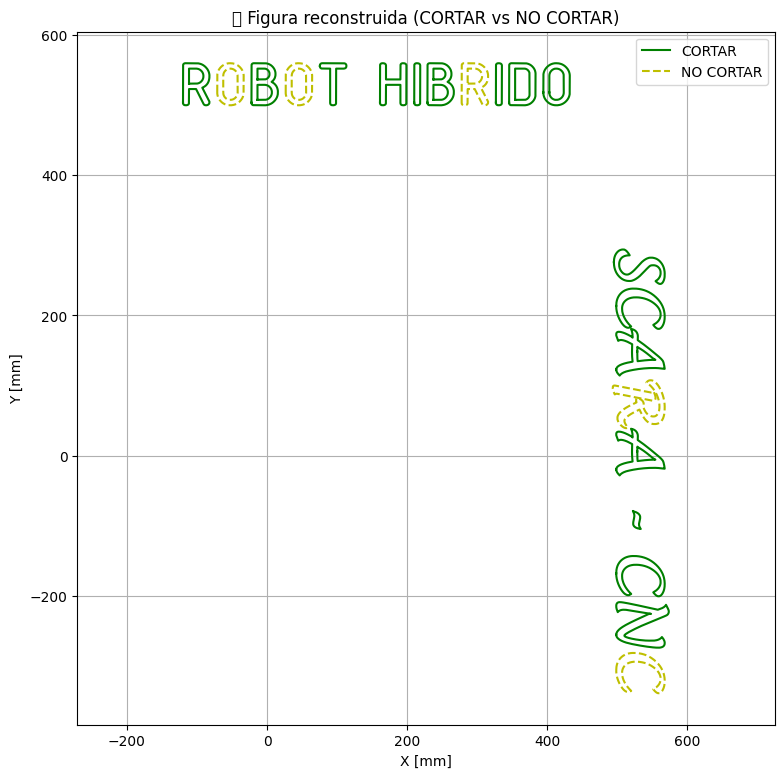

✅ Exportado: TrayectoriaScaraCnc.txt


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

📤 Descarga lista para MATLAB o simulador SCARA.


In [ ]:
# =============================================================
# 🦾 CONVERSOR DXF → TXT SCARA-CNC (topología + color + cortar flag)
# Harold & Abril · versión unificada estable · 2025
# =============================================================

!pip install ezdxf shapely matplotlib numpy scipy scikit-learn --quiet

import ezdxf
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import LineString, MultiLineString
from shapely.ops import linemerge, unary_union
from scipy.interpolate import splprep, splev
from sklearn.cluster import DBSCAN
from google.colab import files

# -------------------------------------------------------------
# 1️⃣ SUBIR ARCHIVO DXF
# -------------------------------------------------------------
print("📂 Sube el archivo DXF que deseas procesar:")
uploaded = files.upload()
dxf_file = list(uploaded.keys())[0]
print(f"✅ Archivo cargado: {dxf_file}")

# -------------------------------------------------------------
# 2️⃣ LECTOR DXF UNIVERSAL (XY + color)
# -------------------------------------------------------------
doc = ezdxf.readfile(dxf_file)
msp = doc.modelspace()
geoms = []

def procesar_entidad(e):
    dtype = e.dxftype()
    color = e.dxf.color
    layer = e.dxf.layer
    puntos = []
    try:
        if dtype == "LINE":
            start, end = e.dxf.start, e.dxf.end
            puntos = [[start.x, start.y], [end.x, end.y]]
        elif dtype == "LWPOLYLINE":
            pts = np.array(e.get_points())[:, :2]
            puntos = pts
        elif dtype == "POLYLINE":
            pts = [v.dxf.location[:2] for v in e.vertices]
            puntos = np.array(pts)
        elif dtype == "CIRCLE":
            c, r = e.dxf.center, e.dxf.radius
            t = np.linspace(0, 2*np.pi, 200)
            puntos = np.column_stack([c.x + r*np.cos(t), c.y + r*np.sin(t)])
        elif dtype == "ARC":
            c, r = e.dxf.center, e.dxf.radius
            a1, a2 = np.deg2rad(e.dxf.start_angle), np.deg2rad(e.dxf.end_angle)
            t = np.linspace(a1, a2, 120)
            puntos = np.column_stack([c.x + r*np.cos(t), c.y + r*np.sin(t)])
        elif dtype == "SPLINE":
            fit = np.array(e.fit_points)
            if len(fit) >= 2:
                tck, _ = splprep([fit[:,0], fit[:,1]], s=0)
                u = np.linspace(0, 1, 200)
                x, y = splev(u, tck)
                puntos = np.column_stack([x, y])
            else:
                ctrl = np.array(e.control_points)
                if len(ctrl) >= 2:
                    tck, _ = splprep([ctrl[:,0], ctrl[:,1]], s=0)
                    u = np.linspace(0, 1, 200)
                    x, y = splev(u, tck)
                    puntos = np.column_stack([x, y])
        if len(puntos) > 1:
            geoms.append({"geom": LineString(puntos), "color": color, "layer": layer})
    except Exception as ex:
        print(f"⚠️ No se pudo procesar {dtype}: {ex}")

for e in msp:
    procesar_entidad(e)

if not geoms:
    raise ValueError("⚠️ No se detectaron entidades válidas en el DXF.")

# -------------------------------------------------------------
# 3️⃣ SEPARAR POR COLOR (CORTAR / NO CORTAR)
# -------------------------------------------------------------
def clasificar_color(color, layer):
    if color == 2 or "NO" in layer.upper():
        return "NO_CORTAR"
    else:
        return "CORTAR"

geoms_cortar = [g["geom"] for g in geoms if clasificar_color(g["color"], g["layer"]) == "CORTAR"]
geoms_nocortar = [g["geom"] for g in geoms if clasificar_color(g["color"], g["layer"]) == "NO_CORTAR"]

print(f"✂️ Figuras a cortar: {len(geoms_cortar)}")
print(f"🚫 Figuras NO cortar: {len(geoms_nocortar)}")

# -------------------------------------------------------------
# 4️⃣ FUNCIONES AUXILIARES DE AGRUPACIÓN (DBSCAN + UNION)
# -------------------------------------------------------------
def unir_topologicamente(geoms, tolerancia=0.05):
    if not geoms:
        return []
    endpoints = []
    for gi, g in enumerate(geoms):
        coords = list(g.coords)
        endpoints.append(coords[0])
        endpoints.append(coords[-1])
    endpoints = np.array(endpoints)
    labels = DBSCAN(eps=tolerancia, min_samples=1).fit_predict(endpoints)
    n_clusters = labels.max() + 1
    centroids = np.zeros((n_clusters, 2))
    for k in range(n_clusters):
        pts = endpoints[labels == k]
        centroids[k] = pts.mean(axis=0)
    geoms_sanitized = []
    for gi, g in enumerate(geoms):
        coords = list(g.coords)
        label_start = labels[2*gi]
        label_end = labels[2*gi + 1]
        new_coords = coords.copy()
        new_coords[0] = tuple(centroids[label_start])
        new_coords[-1] = tuple(centroids[label_end])
        geoms_sanitized.append(LineString(new_coords))
    union = unary_union(geoms_sanitized)
    merged = linemerge(union)
    if isinstance(merged, LineString):
        merged = [merged]
    elif isinstance(merged, MultiLineString):
        merged = list(merged.geoms)
    return merged

# -------------------------------------------------------------
# 5️⃣ UNIR CADA CATEGORÍA
# -------------------------------------------------------------
merged_cortar = unir_topologicamente(geoms_cortar)
merged_nocortar = unir_topologicamente(geoms_nocortar)

print(f"✅ Trayectorias finales: cortar = {len(merged_cortar)}, no cortar = {len(merged_nocortar)}")

# -------------------------------------------------------------
# 6️⃣ GRAFICAR RESULTADO
# -------------------------------------------------------------
plt.figure(figsize=(9,9))
for i, g in enumerate(merged_cortar):
    x, y = g.xy
    plt.plot(x, y, 'g-', linewidth=1.5, label="CORTAR" if i==0 else "")
for i, g in enumerate(merged_nocortar):
    x, y = g.xy
    plt.plot(x, y, 'y--', linewidth=1.5, label="NO CORTAR" if i==0 else "")
plt.axis('equal')
plt.title("🧩 Figura reconstruida (CORTAR vs NO CORTAR)")
plt.xlabel("X [mm]")
plt.ylabel("Y [mm]")
plt.grid(True)
plt.legend()
plt.show()

# -------------------------------------------------------------
# 7️⃣ EXPORTAR TODO EN UN SOLO TXT
# -------------------------------------------------------------
def exportar_txt_unico(nombre, geoms_cortar, geoms_nocortar):
    with open(nombre, 'w') as f:
        f.write("X Y Z CORTAR\n")
        # Primero cortar
        for geom in geoms_cortar:
            x, y = geom.xy
            for xi, yi in zip(x, y):
                f.write(f"{xi:.6f} {yi:.6f} 0.000 1\n")
            f.write("NaN NaN NaN NaN\n")
        # Luego no cortar
        for geom in geoms_nocortar:
            x, y = geom.xy
            for xi, yi in zip(x, y):
                f.write(f"{xi:.6f} {yi:.6f} 0.000 0\n")
            f.write("NaN NaN NaN NaN\n")
    print(f"✅ Exportado: {nombre}")
    files.download(nombre)

exportar_txt_unico("TrayectoriaScaraCnc.txt", merged_cortar, merged_nocortar)

print("📤 Descarga lista para MATLAB o simulador SCARA.")


In [ ]:
# =============================================================
# 🦾 CONVERSOR DXF → TXT SCARA-CNC (PRO) — Jerarquía + Orden interno
# Harold & Abril · versión profesional · 2025
# =============================================================
!pip install ezdxf shapely matplotlib numpy scipy scikit-learn --quiet

import ezdxf
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import LineString, MultiLineString, Polygon, LinearRing, Point
from shapely.ops import linemerge, unary_union, polygonize
from scipy.interpolate import splprep, splev
from sklearn.cluster import DBSCAN
from google.colab import files
import math
import io
import sys

# -------------------------
# Parámetros que puedes ajustar
# -------------------------
TOL_TOPO = 0.05          # tolerancia para unir extremos (mm)
EXPORT_IN_METERS = True  # True -> divide por 1000 al exportar
INTERPOLATION_POINTS = 200 # puntos para CIRCLE/ARC/SPLINE
MIN_RING_LEN = 1e-6      # tolerancia para descartar anillos degenerados
SIMPLIFY_TOLERANCE = 0.01 # <--- NUEVO: Tolerancia para simplificar polígonos (en mm)
# -------------------------------------------------------------
# 1️⃣ SUBIR ARCHIVO DXF (CÓDIGO CORREGIDO)
# -------------------------------------------------------------
print("📂 Sube el archivo DXF que deseas procesar:")
try:
    # files.upload() bloquea la ejecución hasta que se selecciona un archivo o se cancela.
    uploaded = files.upload()
except Exception as e:
    # Esto atrapa errores de entorno, no necesariamente cancelación
    print(f"⚠️ Error durante la subida de archivos: {e}")
    # Si files.upload falla, inicializamos uploaded como vacío para que falle la siguiente comprobación.
    uploaded = {}

if not uploaded:
    print("❌ No se subió ningún archivo o el proceso fue cancelado.")
    # Detenemos el script de forma limpia
    sys.exit("Proceso terminado: No se seleccionó ningún archivo DXF.")
else:
    # Si subió algo, tomamos el nombre del primer archivo subido.
    dxf_file = list(uploaded.keys())[0]
    print(f"✅ Archivo cargado: {dxf_file}")

# -------------------------------------------------------------
# 2️⃣ LECTOR DXF UNIVERSAL (XY + color + layer)
# -------------------------------------------------------------
doc = ezdxf.readfile(dxf_file)
msp = doc.modelspace()
geoms = []

def procesar_entidad(e):
    dtype = e.dxftype()
    color = None
    layer = None
    try:
        color = int(e.dxf.color) if hasattr(e.dxf, "color") else None
    except Exception:
        color = None
    try:
        layer = str(e.dxf.layer) if hasattr(e.dxf, "layer") else ""
    except Exception:
        layer = ""
    puntos = None
    try:
        if dtype == "LINE":
            start, end = e.dxf.start, e.dxf.end
            puntos = np.array([[start.x, start.y], [end.x, end.y]])
        elif dtype == "LWPOLYLINE":
            pts = np.array(e.get_points())[:, :2]
            puntos = pts
        elif dtype == "POLYLINE":
            pts = [v.dxf.location[:2] for v in e.vertices]
            puntos = np.array(pts)
        elif dtype == "CIRCLE":
            c, r = e.dxf.center, e.dxf.radius
            t = np.linspace(0, 2*np.pi, INTERPOLATION_POINTS)
            puntos = np.column_stack([c.x + r*np.cos(t), c.y + r*np.sin(t)])
        elif dtype == "ARC":
            c, r = e.dxf.center, e.dxf.radius
            a1, a2 = np.deg2rad(e.dxf.start_angle), np.deg2rad(e.dxf.end_angle)
            # Manejar arcs que pasan por 0 grados
            if a2 < a1:
                a2 += 2*np.pi
            t = np.linspace(a1, a2, max(10, INTERPOLATION_POINTS//2))
            puntos = np.column_stack([c.x + r*np.cos(t), c.y + r*np.sin(t)])
        elif dtype == "SPLINE":
            # Intentar fit points luego control points
            try:
                fit = np.array(e.fit_points)
            except Exception:
                fit = np.array([])
            if fit is not None and len(fit) >= 2:
                tck, _ = splprep([fit[:,0], fit[:,1]], s=0)
                u = np.linspace(0, 1, INTERPOLATION_POINTS)
                x, y = splev(u, tck)
                puntos = np.column_stack([x, y])
            else:
                try:
                    ctrl = np.array(e.control_points)
                except Exception:
                    ctrl = np.array([])
                if len(ctrl) >= 2:
                    tck, _ = splprep([ctrl[:,0], ctrl[:,1]], s=0)
                    u = np.linspace(0, 1, INTERPOLATION_POINTS)
                    x, y = splev(u, tck)
                    puntos = np.column_stack([x, y])
        # Si obtuvimos puntos los convertimos a LineString
        if puntos is not None and len(puntos) > 1:
            # eliminar duplicados consecutivos
            pts = [tuple(p) for p in puntos]
            pts_clean = [pts[0]]
            for p in pts[1:]:
                if p != pts_clean[-1]:
                    pts_clean.append(p)
            if len(pts_clean) > 1:
                geoms.append({"geom": LineString(pts_clean), "color": color, "layer": layer, "type": dtype})
    except Exception as ex:
        print(f"⚠️ No se pudo procesar {dtype}: {ex}")

for e in msp:
    procesar_entidad(e)

if not geoms:
    raise ValueError("⚠️ No se detectaron entidades válidas en el DXF.")

# -------------------------------------------------------------
# 3️⃣ SEPARAR POR COLOR (CORTAR / NO CORTAR)
# -------------------------------------------------------------
def clasificar_color(color, layer):
    # regla simple: color 2 o capas con "NO" => NO_CORTAR (ajusta a tu convención)
    if color is not None and int(color) == 2:
        return "NO_CORTAR"
    if isinstance(layer, str) and "NO" in layer.upper():
        return "NO_CORTAR"
    return "CORTAR"

geoms_cortar = [g["geom"] for g in geoms if clasificar_color(g["color"], g["layer"]) == "CORTAR"]
geoms_nocortar = [g["geom"] for g in geoms if clasificar_color(g["color"], g["layer"]) == "NO_CORTAR"]

print(f"✂️ Figuras a cortar (raw): {len(geoms_cortar)}")
print(f"🚫 Figuras NO cortar (raw): {len(geoms_nocortar)}")

# -------------------------------------------------------------
# 4️⃣ UNIR TOPOLOGICAMENTE (agrupar segmentos que conectan)
# -------------------------------------------------------------
def unir_topologicamente(geoms, tolerancia=TOL_TOPO):
    if not geoms:
        return []
    endpoints = []
    for gi, g in enumerate(geoms):
        coords = list(g.coords)
        endpoints.append(coords[0])
        endpoints.append(coords[-1])
    endpoints = np.array(endpoints)
    if len(endpoints) == 0:
        return []
    labels = DBSCAN(eps=tolerancia, min_samples=1).fit_predict(endpoints)
    n_clusters = labels.max() + 1
    centroids = np.zeros((n_clusters, 2))
    for k in range(n_clusters):
        pts = endpoints[labels == k]
        centroids[k] = pts.mean(axis=0)
    geoms_sanitized = []
    for gi, g in enumerate(geoms):
        coords = list(g.coords)
        label_start = labels[2*gi]
        label_end = labels[2*gi + 1]
        new_coords = coords.copy()
        new_coords[0] = tuple(centroids[label_start])
        new_coords[-1] = tuple(centroids[label_end])
        # evitar duplicados extremos
        if len(new_coords) >= 2 and new_coords[0] == new_coords[-1]:
            ls = LineString(new_coords)
        else:
            ls = LineString(new_coords)
        geoms_sanitized.append(ls)
    union = unary_union(geoms_sanitized)
    merged = linemerge(union)
    merged_list = []
    if isinstance(merged, LineString):
        merged_list = [merged]
    elif isinstance(merged, MultiLineString):
        merged_list = list(merged.geoms)
    else:
        # fallback: if union is Multi* or GeometryCollection try to extract lines
        try:
            for g in merged:
                if isinstance(g, LineString):
                    merged_list.append(g)
        except Exception:
            pass
    return merged_list

merged_cortar = unir_topologicamente(geoms_cortar, tolerancia=TOL_TOPO)
merged_nocortar = unir_topologicamente(geoms_nocortar, tolerancia=TOL_TOPO)

print(f"✅ Trayectorias parcialmente unidas: cortar = {len(merged_cortar)}, no cortar = {len(merged_nocortar)}")

# -------------------------------------------------------------
# 5️⃣ EXTRACCIÓN DE ANILLOS (RINGS) y LÍNEAS ABIERTAS
#     Además intentamos polygonize para captar polígonos formados por múltiples segmentos
# -------------------------------------------------------------
def extract_rings_and_openlines(merged_list):
    rings = [] # list of LineString that are closed loops
    open_lines = [] # list of open LineString
    # primero polygonize desde la union de las líneas (para formar polígonos con huecos)
    try:
        u = unary_union(merged_list)
        polys = list(polygonize(u))
    except Exception:
        polys = []
    # If polygonize found polygons, extract their exterior and interiors as rings:
    for p in polys:
        try:
            ext = LineString(p.exterior.coords)
            if ext.length > MIN_RING_LEN:
                rings.append(ext)
        except Exception:
            pass
        # interiores (holes)
        for hole in p.interiors:
            try:
                h = LineString(hole.coords)
                if h.length > MIN_RING_LEN:
                    rings.append(h)
            except Exception:
                pass
    # ahora los merged_list originales: si son rings añádelos (si no ya fueron capturados)
    for g in merged_list:
        try:
            coords = list(g.coords)
            if len(coords) >= 4 and (np.allclose(coords[0], coords[-1]) or g.is_ring):
                # cerrado
                if g.length > MIN_RING_LEN:
                    # comprobar si similar a algún ring ya capturado (evitar duplicados)
                    dup = False
                    for r in rings:
                        if abs(r.length - g.length) < 1e-6 and Point(r.centroid).distance(Point(g.centroid)) < 1e-6:
                            dup = True
                            break
                    if not dup:
                        rings.append(LineString(g.coords))
                else:
                    # muy pequeño -> ignorar
                    pass
            else:
                open_lines.append(g)
        except Exception:
            open_lines.append(g)
    return rings, open_lines

rings_cortar, open_cortar = extract_rings_and_openlines(merged_cortar)
rings_nocortar, open_nocortar = extract_rings_and_openlines(merged_nocortar)

print(f"🔁 Rings (cerrados) detectar: cortar={len(rings_cortar)}, no_cortar={len(rings_nocortar)}")
print(f"⚡ Líneas abiertas: cortar={len(open_cortar)}, no_cortar={len(open_nocortar)}")

# -------------------------------------------------------------
# 6️⃣ CREAR POLYGONOS (para test de contención) a partir de rings
#    APLICACIÓN DE SIMPLIFICACIÓN AQUÍ PARA MAYOR VELOCIDAD
# -------------------------------------------------------------
def ring_to_polygon(ring_ls, tolerance=SIMPLIFY_TOLERANCE):
    try:
        coords = list(ring_ls.coords)
        # si el ring no está cerrado, cerrarlo
        if not np.allclose(coords[0], coords[-1]):
            coords = coords + [coords[0]]
        poly = Polygon(coords)

        # *** OPTIMIZACIÓN DE VELOCIDAD ***
        if tolerance > 0:
            poly = poly.simplify(tolerance, preserve_topology=True)
        # **********************************

        if not poly.is_valid:
            poly = poly.buffer(0) # intento de saneamiento
        if poly.is_valid and poly.area > 0:
            return poly
    except Exception as e:
        # print(f"⚠️ Error al convertir a polígono: {e}") # Descomentar para debug
        pass
    return None

polys_cortar = []
ring_to_poly_map = {} # map polygon -> original ring
for r in rings_cortar:
    p = ring_to_polygon(r)
    if p is not None:
        polys_cortar.append(p)
        ring_to_poly_map[id(p)] = r

# -------------------------------------------------------------
# 7️⃣ DETECTAR JERARQUÍAS (PADRE-HIJO) entre polígonos/cierres
# -------------------------------------------------------------
def build_supergroups(polys):
    n = len(polys)
    parents = [-1]*n
    areas = [polys[i].area for i in range(n)]
    for i in range(n):
        # buscar contenedores de polys[i]
        candidates = []
        pi = polys[i]
        # representative point for robust within check
        rep = pi.representative_point()
        for j in range(n):
            if i == j: continue
            pj = polys[j]
            # si pj contiene el punto representativo de pi -> pj es candidato a padre
            if pj.contains(rep):
                candidates.append((areas[j], j))
        if candidates:
            # elegir el padre con menor area que aún contenga (es el más cercano)
            candidates.sort()
            parents[i] = candidates[0][1]
    # construir árbol de grupos: cada root (parent == -1) define un supergrupo
    supergroups = {}
    for i in range(n):
        # ascender hasta la raiz
        root = i
        while parents[root] != -1:
            root = parents[root]
        if root not in supergroups:
            supergroups[root] = []
        supergroups[root].append(i)
    return supergroups, parents

supergroups_cortar, parents_cortar = build_supergroups(polys_cortar)
print(f"✅ Jerarquía calculada. Tiempo consumido en {len(polys_cortar)} polígonos.") # <--- MENSAJE DE DIAGNÓSTICO
print(f"📂 Supergrupos detectados (polígonos cortar): {len(supergroups_cortar)}")

# -------------------------------------------------------------
# 8️⃣ FORMATEAR SUPERGRUPOS: convertir índices a LineStrings (contornos)
# -------------------------------------------------------------
def poly_index_to_contours(poly_indices, polys, ring_map):
    contours = []
    for idx in poly_indices:
        p = polys[idx]
        # exterior
        try:
            ext_ring = LineString(p.exterior.coords)
            contours.append(ext_ring)
        except Exception:
            pass
        # holes
        for hole in p.interiors:
            try:
                hole_ls = LineString(hole.coords)
                contours.append(hole_ls)
            except Exception:
                pass
    return contours

# construir lista de supergrupos con sus contornos ordenados
supergroup_contours = []
for root, members in supergroups_cortar.items():
    contours = poly_index_to_contours(members, polys_cortar, ring_to_poly_map)
    # ordenar por longitud (asc)
    contours_sorted = sorted(contours, key=lambda c: c.length)
    supergroup_contours.append(contours_sorted)

# -------------------------------------------------------------
# 9️⃣ AÑADIR RINGS QUE NO FORMARON PARTE DE NINGÚN polígono (casos aislados)
# -------------------------------------------------------------
# id set of rings already in polys
polys_rings_ids = set()
for idx, p in enumerate(polys_cortar):
    polys_rings_ids.add(id(ring_to_poly_map[id(p)]))

# collect rings that were not polygonized -> compare by centroid/length
remaining_rings = []
for r in rings_cortar:
    # check if similar ring exists in already used polygons
    used = False
    for p in polys_cortar:
        r_used = ring_to_poly_map.get(id(p), None)
        if r_used is None:
            continue
        if abs(r_used.length - r.length) < 1e-6 and Point(r.centroid).distance(Point(r_used.centroid)) < 1e-6:
            used = True
            break
    if not used:
        remaining_rings.append(r)

# add each remaining ring as its own supergroup (single contour)
for r in remaining_rings:
    supergroup_contours.append([r])

# -------------------------------------------------------------
# 10️⃣ LÍNEAS ABIERTAS Y POLILÍNEAS NO-ANIDADAS:
# -------------------------------------------------------------
# open_cortar contiene líneas abiertas resultado de la unión
open_groups = [[ln] for ln in sorted(open_cortar, key=lambda l: l.length)]

# -------------------------------------------------------------
# 11️⃣ CREAR SECUENCIA FINAL DE CORTE:
# -------------------------------------------------------------
final_cut_sequence = []
# añadir supergrupos
for sg in supergroup_contours:
    # sg ya está ordenado internamente (short->long)
    final_cut_sequence.append(sg)

# añadir open groups
for og in open_groups:
    final_cut_sequence.append(og)

print(f"🔢 Secuencia de corte (grupos): {len(final_cut_sequence)}")

# -------------------------------------------------------------
# 12️⃣ PREPARAR SECUENCIA NO_CORTAR (similar, pero no afecta nesting)
# -------------------------------------------------------------
final_nocut_sequence = []
# attempt to create rings for no-cut too
for r in rings_nocortar:
    final_nocut_sequence.append([r])
for ln in sorted(open_nocortar, key=lambda l: l.length):
    final_nocut_sequence.append([ln])
print(f"ℹ️ Secuencia NO_CORTAR (grupos): {len(final_nocut_sequence)}")

# -------------------------------------------------------------
# 13️⃣ GRAFICAR RESULTADO (para ver jerarquía y orden)
# -------------------------------------------------------------
plt.figure(figsize=(9,9))
# colors: supergroups (CORTAR) - draw interior contours first with dotted for visibility
for gi, sg in enumerate(final_cut_sequence):
    for ci, contour in enumerate(sg):
        x, y = contour.xy
        # interiores (más cortos) pintarlos con azul, exterior con green
        if ci < len(sg)-1:
            plt.plot(x, y, linestyle='--', linewidth=1.3, label="CORTAR (interior)" if gi==0 and ci==0 else "")
        else:
            plt.plot(x, y, linestyle='-', linewidth=1.7, label="CORTAR (exterior)" if gi==0 else "")
# open groups already included above
# ahora no cortar
for i, sg in enumerate(final_nocut_sequence):
    for contour in sg:
        x, y = contour.xy
        plt.plot(x, y, linestyle=':', linewidth=1.2, label="NO_CORTAR" if i==0 else "")

plt.axis('equal')
plt.title("🧩 Jerarquía & Orden de Corte (interior primero → exterior último)")
plt.xlabel("X [mm]")
plt.ylabel("Y [mm]")
plt.grid(True)
plt.legend()
plt.show()

# -------------------------------------------------------------
# 14️⃣ EXPORTAR TODO EN UN SOLO TXT (orden correcto)
# -------------------------------------------------------------
def export_sequence_to_txt(filename, cut_seq, nocut_seq, export_in_meters=EXPORT_IN_METERS):
    factor = 0.001 if export_in_meters else 1.0
    out = io.StringIO()
    out.write("# X Y Z CUT_FLAG\n")
    # cortar primero según sequence (cada grupo puede tener varias cadenas; cada cadena es LineString)
    for gidx, group in enumerate(cut_seq):
        for chain in group:
            x, y = chain.xy
            for xi, yi in zip(x, y):
                out.write(f"{xi*factor:.6f} {yi*factor:.6f} 0.000 1\n")
            # separador de cadena
            out.write("NaN NaN NaN NaN\n")
        # separador de grupo (opcional, ya tenemos NaN)
    # luego objetos NO_CORTAR
    for gidx, group in enumerate(nocut_seq):
        for chain in group:
            x, y = chain.xy
            for xi, yi in zip(x, y):
                out.write(f"{xi*factor:.6f} {yi*factor:.6f} 0.000 0\n")
            out.write("NaN NaN NaN NaN\n")
    # escribir archivo y lanzar descarga
    content = out.getvalue()
    with open(filename, 'w') as f:
        f.write(content)
    print(f"✅ Exportado: {filename}  (en metros: {export_in_meters})")
    files.download(filename)

export_sequence_to_txt("TrayectoriaScaraCnc_PRO.txt", final_cut_sequence, final_nocut_sequence, EXPORT_IN_METERS)

print("📤 Proceso completado. Descarga lista para MATLAB / simulador SCARA.")

📂 Sube el archivo DXF que deseas procesar:


Saving logo7.DXF to logo7 (1).DXF
✅ Archivo cargado: logo7 (1).DXF
✂️ Figuras a cortar (raw): 130
🚫 Figuras NO cortar (raw): 0
✅ Trayectorias parcialmente unidas: cortar = 10, no cortar = 0
🔁 Rings (cerrados) detectar: cortar=14, no_cortar=0
⚡ Líneas abiertas: cortar=0, no_cortar=0
